In [1]:
# Exercise_2
# main simple regression WHO data
# TODO**
# Names of group members: Fabian Bloch and Christopher Mahn
# Date: April 24th, 2023
# TODO**

In [2]:
#%% Load modules
import numpy as np
import pandas as pd
# import csv

# torch modules
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# plot module
import matplotlib.pyplot as plt

# module for interoperable file-operations
import os
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
print(f'Path of this exercise: {path}')

Path of this exercise: /hdd/repository/hcu-ma-gmt-big-data-analysis/data/ex2


In [3]:
# %% CUDA for PyTorch
# Right at the beginning: check if a cuda compatible GPU is available in your computer. 
# If so, set device = cuda:0 which means that later all calculations will be performed on the graphics card. 
# If no GPU is available, the calculations will run on the CPU, which is also absolutely sufficient for the examples in these exercises.
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
# cudnn.benchmark = True
if(use_cuda):
    print(f'Found: {torch.cuda.get_device_name()}')
if device.type == 'cpu':
    device_num = 0
    print('No GPU available.')
else:
    device_num = torch.cuda.device_count()
    print('Device:', device, '-- Number of devices:', device_num)

Found: NVIDIA GeForce RTX 3080 Ti
Device: cuda -- Number of devices: 1


In [4]:
# Mounting Google Drive locally 
# from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
# drive.mount('/content/drive')
# you can also choose one of the other options to load data
# therefore see https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA

In [5]:
# %% read data
# path to WHO data
data_path = os.path.join(path, 'data/life-expectancy-who/Life Expectancy Data.csv')

# read csv sheet with pandas
df = pd.read_csv(data_path)

# drop each row where is nan data
df = df.dropna()
# drop each row where is not at least 21 not nan data
# df = df.dropna(thresh=21) # there are many nan in row 4 12 14, which can cause errors

# get numpy out of pandas dataframe
data = df.values
# data=df.to_numpy()

# get column names to see, which columns we have to extract as x and y
column_names = np.array(df.columns[:], dtype=np.str_)

# TODO**
print(f'Dimension of the dataset: {np.shape(data)}')
# TODO**

Dimension of the dataset: (1649, 22)


In [6]:
# %% split in X and Y
# extract any feature you want as X 
# extract target values as Y
# TODO**
x = np.array(data[:,10], dtype=np.float32)
y = np.array(data[:,3], dtype=np.float32)
# TODO**
print('x shape:', x.shape)
print('y shape:', y.shape)
print(f'x_1 = {x[0]:.1f} = 19.1')
print(f'y_1 = {y[0]:.1f} = 65.0')

x shape: (1649,)
y shape: (1649,)
x_1 = 19.1 = 19.1
y_1 = 65.0 = 65.0


In [7]:
# %% normalize X and Y between (0,1). If multiple features in X are selected, each feature is normalized individually
scale_x = np.max(x, axis=0)
scale_y = np.max(y, axis=0)
x = x/scale_x
y = y/scale_y
print('Scale_x:',scale_x)
print('Scale_y:',scale_y)

Scale_x: 77.1
Scale_y: 89.0


In [8]:
# %% convert to torch tensors
# if tensors have only one dimension, an artificial dimension is created with unsqueeze (e.g. [10]->[10,1], so 1D->2D)
Y = torch.from_numpy(y)
Y = Y.float()
if len(Y.shape)==1:
    Y = Y.unsqueeze(dim=1)

X = torch.from_numpy(x)
X = X.float()
if len(X.shape)==1:
    X = X.unsqueeze(dim=1)

In [9]:
# %% Split dataset in training, validation and test tensors
# TODO**
prop_train = 0.5
prop_val = 0.25
prop_test = 0.25
# TODO**

sample_num = {'all': X.shape[0], 
              'train': round(prop_train*X.shape[0]),
              'val': round(prop_val*X.shape[0]),
              'test': round(prop_test*X.shape[0])}

# idx shuffle
idx = np.random.choice(sample_num['all'], sample_num['all'], replace=False)
# assign idx to each sample
sample_idx = {'all': idx[:], 
              'train': idx[0:sample_num['train']],
              'val': idx[sample_num['train']:sample_num['train']+sample_num['val']],
              'test': idx[sample_num['train']+sample_num['val']:]}

# Create train data
X_train = X[sample_idx['train']]
Y_train = Y[sample_idx['train']]

# Create validation data
X_val = X[sample_idx['val']]
Y_val = Y[sample_idx['val']]

# Create test data
X_test = X[sample_idx['test']]
Y_test = Y[sample_idx['test']]


# %% Show data point
print('Input of first ten train Sample:', X_train[0:10])
print('Target of first ten train Sample:', Y_train[0:10])

Input of first ten train Sample: tensor([[0.5901],
        [0.0856],
        [0.3256],
        [0.2438],
        [0.6757],
        [0.2127],
        [0.5460],
        [0.4125],
        [0.9403],
        [0.7588]])
Target of first ten train Sample: tensor([[0.7652],
        [0.8921],
        [0.8753],
        [0.6663],
        [0.8483],
        [0.7180],
        [0.7573],
        [0.8303],
        [0.8157],
        [0.8180]])


In [10]:
#%% class of neural network 'RegressNet'
# set up layer and architecture of network in constructor __init__
# define operations on layer in forward pass method
class RegressNet(nn.Module):
    
    def __init__(self, inputSize, outputSize):
        super(RegressNet, self).__init__()
        self.fc1 = nn.Linear(inputSize, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, outputSize)
    
    def forward(self, x):
        # max pooling over (2, 2) window
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
#%% Specify network hyperparameter and create instance of RegressNet
# TODO**        
inputDim = 1
outputDim = 1

# Create instance of RegressNet
net = RegressNet(inputDim, outputDim)
# TODO**
print(net)

RegressNet(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [12]:
print(torch.version.cuda)

#%% Send tensors and networks to GPU (if you have one which supports cuda) for faster computations
X_train, Y_train = X_train.to(device), Y_train.to(device)
X_val, Y_val = X_val.to(device), Y_val.to(device)
X_test, Y_test = X_test.to(device), Y_test.to(device)

# The network itself must also be sent to the GPU. Either you write net = RegressNet() and then later net.to(device) or directly net = RegressNet().to(device)
# The latter option may have the advantage that the instance net is created directly on the GPU, whereas in variant 1 it must first be sent to the GPU.
if device_num>1:
    print("Let's use", device_num, "GPU's")
    net = nn.DataParallel(net)
net.to(device)

11.7


RegressNet(
  (fc1): Linear(in_features=1, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
#%% Specify hyperparameter
# hyperparemter: num_epoch, num_lr, loss_func, optimizer
# how many epochs do we want to train?
# TODO** 
num_epoch = 10000
learn_rate = 1e-3
# TODO**
# Loss and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learn_rate)

In [14]:
#%% Loss before training
# Compute loss of test data before training the network (with random weights)
Y_pred_train_before = net(X_train)
loss_train_before = loss_func(Y_pred_train_before, Y_train)
Y_pred_val_before = net(X_val)
loss_val_before = loss_func(Y_pred_val_before, Y_val)
Y_pred_test_before = net(X_test)
loss_test_before = loss_func(Y_pred_test_before, Y_test)

Train Epoch: 1/10000 (0%)	train_Loss: 0.886519	val_Loss: 0.761588
Train Epoch: 2/10000 (0%)	train_Loss: 0.764846	val_Loss: 0.650591
Train Epoch: 3/10000 (0%)	train_Loss: 0.654211	val_Loss: 0.555164
Train Epoch: 4/10000 (0%)	train_Loss: 0.558727	val_Loss: 0.476749
Train Epoch: 5/10000 (0%)	train_Loss: 0.480123	val_Loss: 0.411897
Train Epoch: 6/10000 (0%)	train_Loss: 0.415249	val_Loss: 0.355852
Train Epoch: 7/10000 (0%)	train_Loss: 0.359199	val_Loss: 0.307406
Train Epoch: 8/10000 (0%)	train_Loss: 0.310665	val_Loss: 0.263363
Train Epoch: 9/10000 (0%)	train_Loss: 0.266414	val_Loss: 0.222888
Train Epoch: 10/10000 (0%)	train_Loss: 0.225815	val_Loss: 0.186277
Train Epoch: 11/10000 (0%)	train_Loss: 0.189017	val_Loss: 0.153628
Train Epoch: 12/10000 (0%)	train_Loss: 0.156250	val_Loss: 0.124820
Train Epoch: 13/10000 (0%)	train_Loss: 0.127315	val_Loss: 0.099748
Train Epoch: 14/10000 (0%)	train_Loss: 0.102099	val_Loss: 0.078592
Train Epoch: 15/10000 (0%)	train_Loss: 0.080740	val_Loss: 0.060648
Trai

Train Epoch: 137/10000 (1%)	train_Loss: 0.006102	val_Loss: 0.006601
Train Epoch: 138/10000 (1%)	train_Loss: 0.006099	val_Loss: 0.006599
Train Epoch: 139/10000 (1%)	train_Loss: 0.006096	val_Loss: 0.006597
Train Epoch: 140/10000 (1%)	train_Loss: 0.006093	val_Loss: 0.006595
Train Epoch: 141/10000 (1%)	train_Loss: 0.006090	val_Loss: 0.006594
Train Epoch: 142/10000 (1%)	train_Loss: 0.006086	val_Loss: 0.006592
Train Epoch: 143/10000 (1%)	train_Loss: 0.006083	val_Loss: 0.006591
Train Epoch: 144/10000 (1%)	train_Loss: 0.006080	val_Loss: 0.006590
Train Epoch: 145/10000 (1%)	train_Loss: 0.006077	val_Loss: 0.006589
Train Epoch: 146/10000 (1%)	train_Loss: 0.006074	val_Loss: 0.006588
Train Epoch: 147/10000 (1%)	train_Loss: 0.006071	val_Loss: 0.006587
Train Epoch: 148/10000 (1%)	train_Loss: 0.006068	val_Loss: 0.006586
Train Epoch: 149/10000 (1%)	train_Loss: 0.006065	val_Loss: 0.006584
Train Epoch: 150/10000 (1%)	train_Loss: 0.006063	val_Loss: 0.006583
Train Epoch: 151/10000 (2%)	train_Loss: 0.006060

Train Epoch: 298/10000 (3%)	train_Loss: 0.005692	val_Loss: 0.006354
Train Epoch: 299/10000 (3%)	train_Loss: 0.005690	val_Loss: 0.006353
Train Epoch: 300/10000 (3%)	train_Loss: 0.005688	val_Loss: 0.006352
Train Epoch: 301/10000 (3%)	train_Loss: 0.005687	val_Loss: 0.006351
Train Epoch: 302/10000 (3%)	train_Loss: 0.005685	val_Loss: 0.006350
Train Epoch: 303/10000 (3%)	train_Loss: 0.005683	val_Loss: 0.006349
Train Epoch: 304/10000 (3%)	train_Loss: 0.005681	val_Loss: 0.006348
Train Epoch: 305/10000 (3%)	train_Loss: 0.005679	val_Loss: 0.006347
Train Epoch: 306/10000 (3%)	train_Loss: 0.005677	val_Loss: 0.006347
Train Epoch: 307/10000 (3%)	train_Loss: 0.005676	val_Loss: 0.006346
Train Epoch: 308/10000 (3%)	train_Loss: 0.005674	val_Loss: 0.006345
Train Epoch: 309/10000 (3%)	train_Loss: 0.005672	val_Loss: 0.006344
Train Epoch: 310/10000 (3%)	train_Loss: 0.005670	val_Loss: 0.006343
Train Epoch: 311/10000 (3%)	train_Loss: 0.005668	val_Loss: 0.006342
Train Epoch: 312/10000 (3%)	train_Loss: 0.005667

Train Epoch: 455/10000 (5%)	train_Loss: 0.005502	val_Loss: 0.006275
Train Epoch: 456/10000 (5%)	train_Loss: 0.005501	val_Loss: 0.006275
Train Epoch: 457/10000 (5%)	train_Loss: 0.005500	val_Loss: 0.006274
Train Epoch: 458/10000 (5%)	train_Loss: 0.005500	val_Loss: 0.006274
Train Epoch: 459/10000 (5%)	train_Loss: 0.005499	val_Loss: 0.006274
Train Epoch: 460/10000 (5%)	train_Loss: 0.005498	val_Loss: 0.006274
Train Epoch: 461/10000 (5%)	train_Loss: 0.005498	val_Loss: 0.006273
Train Epoch: 462/10000 (5%)	train_Loss: 0.005497	val_Loss: 0.006273
Train Epoch: 463/10000 (5%)	train_Loss: 0.005496	val_Loss: 0.006273
Train Epoch: 464/10000 (5%)	train_Loss: 0.005496	val_Loss: 0.006273
Train Epoch: 465/10000 (5%)	train_Loss: 0.005495	val_Loss: 0.006272
Train Epoch: 466/10000 (5%)	train_Loss: 0.005494	val_Loss: 0.006272
Train Epoch: 467/10000 (5%)	train_Loss: 0.005494	val_Loss: 0.006272
Train Epoch: 468/10000 (5%)	train_Loss: 0.005493	val_Loss: 0.006271
Train Epoch: 469/10000 (5%)	train_Loss: 0.005492

Train Epoch: 594/10000 (6%)	train_Loss: 0.005429	val_Loss: 0.006231
Train Epoch: 595/10000 (6%)	train_Loss: 0.005429	val_Loss: 0.006230
Train Epoch: 596/10000 (6%)	train_Loss: 0.005428	val_Loss: 0.006230
Train Epoch: 597/10000 (6%)	train_Loss: 0.005428	val_Loss: 0.006230
Train Epoch: 598/10000 (6%)	train_Loss: 0.005428	val_Loss: 0.006229
Train Epoch: 599/10000 (6%)	train_Loss: 0.005427	val_Loss: 0.006229
Train Epoch: 600/10000 (6%)	train_Loss: 0.005427	val_Loss: 0.006228
Train Epoch: 601/10000 (6%)	train_Loss: 0.005426	val_Loss: 0.006228
Train Epoch: 602/10000 (6%)	train_Loss: 0.005426	val_Loss: 0.006228
Train Epoch: 603/10000 (6%)	train_Loss: 0.005426	val_Loss: 0.006227
Train Epoch: 604/10000 (6%)	train_Loss: 0.005425	val_Loss: 0.006227
Train Epoch: 605/10000 (6%)	train_Loss: 0.005425	val_Loss: 0.006226
Train Epoch: 606/10000 (6%)	train_Loss: 0.005424	val_Loss: 0.006226
Train Epoch: 607/10000 (6%)	train_Loss: 0.005424	val_Loss: 0.006226
Train Epoch: 608/10000 (6%)	train_Loss: 0.005424

Train Epoch: 746/10000 (7%)	train_Loss: 0.005376	val_Loss: 0.006173
Train Epoch: 747/10000 (7%)	train_Loss: 0.005376	val_Loss: 0.006173
Train Epoch: 748/10000 (7%)	train_Loss: 0.005375	val_Loss: 0.006173
Train Epoch: 749/10000 (7%)	train_Loss: 0.005375	val_Loss: 0.006172
Train Epoch: 750/10000 (7%)	train_Loss: 0.005375	val_Loss: 0.006172
Train Epoch: 751/10000 (8%)	train_Loss: 0.005375	val_Loss: 0.006171
Train Epoch: 752/10000 (8%)	train_Loss: 0.005374	val_Loss: 0.006171
Train Epoch: 753/10000 (8%)	train_Loss: 0.005374	val_Loss: 0.006171
Train Epoch: 754/10000 (8%)	train_Loss: 0.005374	val_Loss: 0.006170
Train Epoch: 755/10000 (8%)	train_Loss: 0.005373	val_Loss: 0.006170
Train Epoch: 756/10000 (8%)	train_Loss: 0.005373	val_Loss: 0.006169
Train Epoch: 757/10000 (8%)	train_Loss: 0.005373	val_Loss: 0.006169
Train Epoch: 758/10000 (8%)	train_Loss: 0.005372	val_Loss: 0.006169
Train Epoch: 759/10000 (8%)	train_Loss: 0.005372	val_Loss: 0.006168
Train Epoch: 760/10000 (8%)	train_Loss: 0.005372

Train Epoch: 901/10000 (9%)	train_Loss: 0.005331	val_Loss: 0.006114
Train Epoch: 902/10000 (9%)	train_Loss: 0.005331	val_Loss: 0.006114
Train Epoch: 903/10000 (9%)	train_Loss: 0.005331	val_Loss: 0.006113
Train Epoch: 904/10000 (9%)	train_Loss: 0.005331	val_Loss: 0.006113
Train Epoch: 905/10000 (9%)	train_Loss: 0.005330	val_Loss: 0.006112
Train Epoch: 906/10000 (9%)	train_Loss: 0.005330	val_Loss: 0.006112
Train Epoch: 907/10000 (9%)	train_Loss: 0.005330	val_Loss: 0.006112
Train Epoch: 908/10000 (9%)	train_Loss: 0.005330	val_Loss: 0.006111
Train Epoch: 909/10000 (9%)	train_Loss: 0.005329	val_Loss: 0.006111
Train Epoch: 910/10000 (9%)	train_Loss: 0.005329	val_Loss: 0.006110
Train Epoch: 911/10000 (9%)	train_Loss: 0.005329	val_Loss: 0.006110
Train Epoch: 912/10000 (9%)	train_Loss: 0.005329	val_Loss: 0.006110
Train Epoch: 913/10000 (9%)	train_Loss: 0.005328	val_Loss: 0.006109
Train Epoch: 914/10000 (9%)	train_Loss: 0.005328	val_Loss: 0.006109
Train Epoch: 915/10000 (9%)	train_Loss: 0.005328

Train Epoch: 1046/10000 (10%)	train_Loss: 0.005299	val_Loss: 0.006066
Train Epoch: 1047/10000 (10%)	train_Loss: 0.005298	val_Loss: 0.006065
Train Epoch: 1048/10000 (10%)	train_Loss: 0.005298	val_Loss: 0.006065
Train Epoch: 1049/10000 (10%)	train_Loss: 0.005298	val_Loss: 0.006064
Train Epoch: 1050/10000 (10%)	train_Loss: 0.005298	val_Loss: 0.006064
Train Epoch: 1051/10000 (10%)	train_Loss: 0.005298	val_Loss: 0.006063
Train Epoch: 1052/10000 (11%)	train_Loss: 0.005298	val_Loss: 0.006063
Train Epoch: 1053/10000 (11%)	train_Loss: 0.005297	val_Loss: 0.006063
Train Epoch: 1054/10000 (11%)	train_Loss: 0.005297	val_Loss: 0.006062
Train Epoch: 1055/10000 (11%)	train_Loss: 0.005297	val_Loss: 0.006061
Train Epoch: 1056/10000 (11%)	train_Loss: 0.005297	val_Loss: 0.006061
Train Epoch: 1057/10000 (11%)	train_Loss: 0.005297	val_Loss: 0.006061
Train Epoch: 1058/10000 (11%)	train_Loss: 0.005296	val_Loss: 0.006060
Train Epoch: 1059/10000 (11%)	train_Loss: 0.005296	val_Loss: 0.006060
Train Epoch: 1060/10

Train Epoch: 1180/10000 (12%)	train_Loss: 0.005275	val_Loss: 0.006028
Train Epoch: 1181/10000 (12%)	train_Loss: 0.005274	val_Loss: 0.006028
Train Epoch: 1182/10000 (12%)	train_Loss: 0.005274	val_Loss: 0.006028
Train Epoch: 1183/10000 (12%)	train_Loss: 0.005274	val_Loss: 0.006027
Train Epoch: 1184/10000 (12%)	train_Loss: 0.005274	val_Loss: 0.006027
Train Epoch: 1185/10000 (12%)	train_Loss: 0.005274	val_Loss: 0.006027
Train Epoch: 1186/10000 (12%)	train_Loss: 0.005274	val_Loss: 0.006027
Train Epoch: 1187/10000 (12%)	train_Loss: 0.005273	val_Loss: 0.006026
Train Epoch: 1188/10000 (12%)	train_Loss: 0.005273	val_Loss: 0.006026
Train Epoch: 1189/10000 (12%)	train_Loss: 0.005273	val_Loss: 0.006026
Train Epoch: 1190/10000 (12%)	train_Loss: 0.005273	val_Loss: 0.006026
Train Epoch: 1191/10000 (12%)	train_Loss: 0.005273	val_Loss: 0.006025
Train Epoch: 1192/10000 (12%)	train_Loss: 0.005273	val_Loss: 0.006025
Train Epoch: 1193/10000 (12%)	train_Loss: 0.005272	val_Loss: 0.006025
Train Epoch: 1194/10

Train Epoch: 1319/10000 (13%)	train_Loss: 0.005253	val_Loss: 0.005999
Train Epoch: 1320/10000 (13%)	train_Loss: 0.005253	val_Loss: 0.005999
Train Epoch: 1321/10000 (13%)	train_Loss: 0.005253	val_Loss: 0.005998
Train Epoch: 1322/10000 (13%)	train_Loss: 0.005253	val_Loss: 0.005998
Train Epoch: 1323/10000 (13%)	train_Loss: 0.005252	val_Loss: 0.005998
Train Epoch: 1324/10000 (13%)	train_Loss: 0.005252	val_Loss: 0.005997
Train Epoch: 1325/10000 (13%)	train_Loss: 0.005252	val_Loss: 0.005997
Train Epoch: 1326/10000 (13%)	train_Loss: 0.005252	val_Loss: 0.005997
Train Epoch: 1327/10000 (13%)	train_Loss: 0.005252	val_Loss: 0.005997
Train Epoch: 1328/10000 (13%)	train_Loss: 0.005252	val_Loss: 0.005997
Train Epoch: 1329/10000 (13%)	train_Loss: 0.005252	val_Loss: 0.005997
Train Epoch: 1330/10000 (13%)	train_Loss: 0.005251	val_Loss: 0.005996
Train Epoch: 1331/10000 (13%)	train_Loss: 0.005251	val_Loss: 0.005996
Train Epoch: 1332/10000 (13%)	train_Loss: 0.005251	val_Loss: 0.005996
Train Epoch: 1333/10

Train Epoch: 1437/10000 (14%)	train_Loss: 0.005239	val_Loss: 0.005976
Train Epoch: 1438/10000 (14%)	train_Loss: 0.005238	val_Loss: 0.005976
Train Epoch: 1439/10000 (14%)	train_Loss: 0.005238	val_Loss: 0.005976
Train Epoch: 1440/10000 (14%)	train_Loss: 0.005238	val_Loss: 0.005976
Train Epoch: 1441/10000 (14%)	train_Loss: 0.005238	val_Loss: 0.005976
Train Epoch: 1442/10000 (14%)	train_Loss: 0.005238	val_Loss: 0.005975
Train Epoch: 1443/10000 (14%)	train_Loss: 0.005238	val_Loss: 0.005975
Train Epoch: 1444/10000 (14%)	train_Loss: 0.005238	val_Loss: 0.005975
Train Epoch: 1445/10000 (14%)	train_Loss: 0.005238	val_Loss: 0.005975
Train Epoch: 1446/10000 (14%)	train_Loss: 0.005238	val_Loss: 0.005975
Train Epoch: 1447/10000 (14%)	train_Loss: 0.005237	val_Loss: 0.005975
Train Epoch: 1448/10000 (14%)	train_Loss: 0.005237	val_Loss: 0.005975
Train Epoch: 1449/10000 (14%)	train_Loss: 0.005237	val_Loss: 0.005974
Train Epoch: 1450/10000 (14%)	train_Loss: 0.005237	val_Loss: 0.005974
Train Epoch: 1451/10

Train Epoch: 1576/10000 (16%)	train_Loss: 0.005223	val_Loss: 0.005954
Train Epoch: 1577/10000 (16%)	train_Loss: 0.005223	val_Loss: 0.005954
Train Epoch: 1578/10000 (16%)	train_Loss: 0.005223	val_Loss: 0.005954
Train Epoch: 1579/10000 (16%)	train_Loss: 0.005223	val_Loss: 0.005954
Train Epoch: 1580/10000 (16%)	train_Loss: 0.005223	val_Loss: 0.005954
Train Epoch: 1581/10000 (16%)	train_Loss: 0.005223	val_Loss: 0.005954
Train Epoch: 1582/10000 (16%)	train_Loss: 0.005223	val_Loss: 0.005953
Train Epoch: 1583/10000 (16%)	train_Loss: 0.005223	val_Loss: 0.005953
Train Epoch: 1584/10000 (16%)	train_Loss: 0.005223	val_Loss: 0.005953
Train Epoch: 1585/10000 (16%)	train_Loss: 0.005223	val_Loss: 0.005953
Train Epoch: 1586/10000 (16%)	train_Loss: 0.005223	val_Loss: 0.005953
Train Epoch: 1587/10000 (16%)	train_Loss: 0.005222	val_Loss: 0.005953
Train Epoch: 1588/10000 (16%)	train_Loss: 0.005222	val_Loss: 0.005953
Train Epoch: 1589/10000 (16%)	train_Loss: 0.005222	val_Loss: 0.005952
Train Epoch: 1590/10

Train Epoch: 1707/10000 (17%)	train_Loss: 0.005214	val_Loss: 0.005938
Train Epoch: 1708/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005937
Train Epoch: 1709/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005937
Train Epoch: 1710/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005937
Train Epoch: 1711/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005937
Train Epoch: 1712/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005937
Train Epoch: 1713/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005937
Train Epoch: 1714/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005937
Train Epoch: 1715/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005937
Train Epoch: 1716/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005937
Train Epoch: 1717/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005938
Train Epoch: 1718/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005938
Train Epoch: 1719/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005938
Train Epoch: 1720/10000 (17%)	train_Loss: 0.005213	val_Loss: 0.005939
Train Epoch: 1721/10

Train Epoch: 1832/10000 (18%)	train_Loss: 0.005206	val_Loss: 0.005927
Train Epoch: 1833/10000 (18%)	train_Loss: 0.005206	val_Loss: 0.005927
Train Epoch: 1834/10000 (18%)	train_Loss: 0.005206	val_Loss: 0.005927
Train Epoch: 1835/10000 (18%)	train_Loss: 0.005206	val_Loss: 0.005927
Train Epoch: 1836/10000 (18%)	train_Loss: 0.005206	val_Loss: 0.005927
Train Epoch: 1837/10000 (18%)	train_Loss: 0.005206	val_Loss: 0.005926
Train Epoch: 1838/10000 (18%)	train_Loss: 0.005205	val_Loss: 0.005926
Train Epoch: 1839/10000 (18%)	train_Loss: 0.005205	val_Loss: 0.005926
Train Epoch: 1840/10000 (18%)	train_Loss: 0.005205	val_Loss: 0.005926
Train Epoch: 1841/10000 (18%)	train_Loss: 0.005205	val_Loss: 0.005926
Train Epoch: 1842/10000 (18%)	train_Loss: 0.005205	val_Loss: 0.005926
Train Epoch: 1843/10000 (18%)	train_Loss: 0.005205	val_Loss: 0.005926
Train Epoch: 1844/10000 (18%)	train_Loss: 0.005205	val_Loss: 0.005926
Train Epoch: 1845/10000 (18%)	train_Loss: 0.005205	val_Loss: 0.005926
Train Epoch: 1846/10

Train Epoch: 1966/10000 (20%)	train_Loss: 0.005200	val_Loss: 0.005918
Train Epoch: 1967/10000 (20%)	train_Loss: 0.005200	val_Loss: 0.005918
Train Epoch: 1968/10000 (20%)	train_Loss: 0.005200	val_Loss: 0.005917
Train Epoch: 1969/10000 (20%)	train_Loss: 0.005200	val_Loss: 0.005917
Train Epoch: 1970/10000 (20%)	train_Loss: 0.005200	val_Loss: 0.005917
Train Epoch: 1971/10000 (20%)	train_Loss: 0.005200	val_Loss: 0.005917
Train Epoch: 1972/10000 (20%)	train_Loss: 0.005200	val_Loss: 0.005917
Train Epoch: 1973/10000 (20%)	train_Loss: 0.005200	val_Loss: 0.005917
Train Epoch: 1974/10000 (20%)	train_Loss: 0.005200	val_Loss: 0.005917
Train Epoch: 1975/10000 (20%)	train_Loss: 0.005199	val_Loss: 0.005917
Train Epoch: 1976/10000 (20%)	train_Loss: 0.005199	val_Loss: 0.005917
Train Epoch: 1977/10000 (20%)	train_Loss: 0.005199	val_Loss: 0.005917
Train Epoch: 1978/10000 (20%)	train_Loss: 0.005199	val_Loss: 0.005917
Train Epoch: 1979/10000 (20%)	train_Loss: 0.005199	val_Loss: 0.005916
Train Epoch: 1980/10

Train Epoch: 2103/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005909
Train Epoch: 2104/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005909
Train Epoch: 2105/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005909
Train Epoch: 2106/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005909
Train Epoch: 2107/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005909
Train Epoch: 2108/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005909
Train Epoch: 2109/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005909
Train Epoch: 2110/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005909
Train Epoch: 2111/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005908
Train Epoch: 2112/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005908
Train Epoch: 2113/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005908
Train Epoch: 2114/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005908
Train Epoch: 2115/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005908
Train Epoch: 2116/10000 (21%)	train_Loss: 0.005195	val_Loss: 0.005908
Train Epoch: 2117/10

Train Epoch: 2233/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2234/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2235/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2236/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2237/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2238/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2239/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2240/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2241/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2242/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2243/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2244/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2245/10000 (22%)	train_Loss: 0.005192	val_Loss: 0.005902
Train Epoch: 2246/10000 (22%)	train_Loss: 0.005191	val_Loss: 0.005902
Train Epoch: 2247/10

Train Epoch: 2359/10000 (24%)	train_Loss: 0.005190	val_Loss: 0.005898
Train Epoch: 2360/10000 (24%)	train_Loss: 0.005190	val_Loss: 0.005898
Train Epoch: 2361/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2362/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2363/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2364/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2365/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2366/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2367/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2368/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2369/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2370/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2371/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2372/10000 (24%)	train_Loss: 0.005189	val_Loss: 0.005898
Train Epoch: 2373/10

Train Epoch: 2479/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005894
Train Epoch: 2480/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005894
Train Epoch: 2481/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2482/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2483/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2484/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2485/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2486/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2487/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2488/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2489/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2490/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2491/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2492/10000 (25%)	train_Loss: 0.005188	val_Loss: 0.005895
Train Epoch: 2493/10

Train Epoch: 2615/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2616/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2617/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2618/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2619/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2620/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2621/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2622/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2623/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2624/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2625/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2626/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2627/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2628/10000 (26%)	train_Loss: 0.005187	val_Loss: 0.005891
Train Epoch: 2629/10

Train Epoch: 2751/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2752/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2753/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2754/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2755/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2756/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2757/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2758/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2759/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2760/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2761/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2762/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2763/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2764/10000 (28%)	train_Loss: 0.005186	val_Loss: 0.005887
Train Epoch: 2765/10

Train Epoch: 2877/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005885
Train Epoch: 2878/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005885
Train Epoch: 2879/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005885
Train Epoch: 2880/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005885
Train Epoch: 2881/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005885
Train Epoch: 2882/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005885
Train Epoch: 2883/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005885
Train Epoch: 2884/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005885
Train Epoch: 2885/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005885
Train Epoch: 2886/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005885
Train Epoch: 2887/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005884
Train Epoch: 2888/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005884
Train Epoch: 2889/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005884
Train Epoch: 2890/10000 (29%)	train_Loss: 0.005186	val_Loss: 0.005884
Train Epoch: 2891/10

Train Epoch: 3002/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3003/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3004/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3005/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3006/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3007/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3008/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3009/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3010/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3011/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3012/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3013/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3014/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3015/10000 (30%)	train_Loss: 0.005186	val_Loss: 0.005883
Train Epoch: 3016/10

Train Epoch: 3121/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005882
Train Epoch: 3122/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005882
Train Epoch: 3123/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005882
Train Epoch: 3124/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005882
Train Epoch: 3125/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005881
Train Epoch: 3126/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005881
Train Epoch: 3127/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005881
Train Epoch: 3128/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005881
Train Epoch: 3129/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005881
Train Epoch: 3130/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005882
Train Epoch: 3131/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005882
Train Epoch: 3132/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005881
Train Epoch: 3133/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005881
Train Epoch: 3134/10000 (31%)	train_Loss: 0.005185	val_Loss: 0.005881
Train Epoch: 3135/10

Train Epoch: 3240/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3241/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3242/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3243/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3244/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005881
Train Epoch: 3245/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005881
Train Epoch: 3246/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3247/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3248/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3249/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3250/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3251/10000 (32%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3252/10000 (33%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3253/10000 (33%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3254/10

Train Epoch: 3369/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3370/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3371/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3372/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3373/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3374/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3375/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3376/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3377/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3378/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005880
Train Epoch: 3379/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3380/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3381/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3382/10000 (34%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3383/10

Train Epoch: 3497/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3498/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3499/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3500/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3501/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3502/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3503/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3504/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3505/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3506/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3507/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3508/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3509/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3510/10000 (35%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3511/10

Train Epoch: 3618/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3619/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3620/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3621/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3622/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3623/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3624/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3625/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3626/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005879
Train Epoch: 3627/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3628/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3629/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3630/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3631/10000 (36%)	train_Loss: 0.005185	val_Loss: 0.005878
Train Epoch: 3632/10

Train Epoch: 3737/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3738/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3739/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3740/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3741/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3742/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3743/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3744/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3745/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3746/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3747/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3748/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3749/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3750/10000 (37%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3751/10

Train Epoch: 3866/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3867/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3868/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3869/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3870/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3871/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3872/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3873/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3874/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3875/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3876/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3877/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3878/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3879/10000 (39%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3880/10

Train Epoch: 3992/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3993/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3994/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005878
Train Epoch: 3995/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3996/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 3997/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005876
Train Epoch: 3998/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005876
Train Epoch: 3999/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005876
Train Epoch: 4000/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 4001/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 4002/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 4003/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 4004/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 4005/10000 (40%)	train_Loss: 0.005184	val_Loss: 0.005877
Train Epoch: 4006/10

Train Epoch: 4117/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4118/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4119/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4120/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4121/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4122/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4123/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005877
Train Epoch: 4124/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005877
Train Epoch: 4125/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005877
Train Epoch: 4126/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005877
Train Epoch: 4127/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4128/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4129/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4130/10000 (41%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4131/10

Train Epoch: 4243/10000 (42%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4244/10000 (42%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4245/10000 (42%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4246/10000 (42%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4247/10000 (42%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4248/10000 (42%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4249/10000 (42%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4250/10000 (42%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4251/10000 (42%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4252/10000 (43%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4253/10000 (43%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4254/10000 (43%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4255/10000 (43%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4256/10000 (43%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4257/10

Train Epoch: 4361/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4362/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4363/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4364/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4365/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4366/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4367/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4368/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005876
Train Epoch: 4369/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4370/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4371/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4372/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4373/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4374/10000 (44%)	train_Loss: 0.005183	val_Loss: 0.005875
Train Epoch: 4375/10

Train Epoch: 4489/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005875
Train Epoch: 4490/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005875
Train Epoch: 4491/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005875
Train Epoch: 4492/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005875
Train Epoch: 4493/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005875
Train Epoch: 4494/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005875
Train Epoch: 4495/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4496/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005875
Train Epoch: 4497/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005875
Train Epoch: 4498/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005875
Train Epoch: 4499/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005875
Train Epoch: 4500/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4501/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4502/10000 (45%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4503/10

Train Epoch: 4618/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4619/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4620/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4621/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4622/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4623/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4624/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4625/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4626/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005873
Train Epoch: 4627/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4628/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4629/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4630/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4631/10000 (46%)	train_Loss: 0.005182	val_Loss: 0.005874
Train Epoch: 4632/10

Train Epoch: 4741/10000 (47%)	train_Loss: 0.005181	val_Loss: 0.005873
Train Epoch: 4742/10000 (47%)	train_Loss: 0.005181	val_Loss: 0.005873
Train Epoch: 4743/10000 (47%)	train_Loss: 0.005181	val_Loss: 0.005873
Train Epoch: 4744/10000 (47%)	train_Loss: 0.005181	val_Loss: 0.005873
Train Epoch: 4745/10000 (47%)	train_Loss: 0.005181	val_Loss: 0.005873
Train Epoch: 4746/10000 (47%)	train_Loss: 0.005181	val_Loss: 0.005874
Train Epoch: 4747/10000 (47%)	train_Loss: 0.005181	val_Loss: 0.005874
Train Epoch: 4748/10000 (47%)	train_Loss: 0.005181	val_Loss: 0.005874
Train Epoch: 4749/10000 (47%)	train_Loss: 0.005181	val_Loss: 0.005873
Train Epoch: 4750/10000 (47%)	train_Loss: 0.005181	val_Loss: 0.005873
Train Epoch: 4751/10000 (48%)	train_Loss: 0.005181	val_Loss: 0.005873
Train Epoch: 4752/10000 (48%)	train_Loss: 0.005181	val_Loss: 0.005874
Train Epoch: 4753/10000 (48%)	train_Loss: 0.005181	val_Loss: 0.005873
Train Epoch: 4754/10000 (48%)	train_Loss: 0.005181	val_Loss: 0.005873
Train Epoch: 4755/10

Train Epoch: 4861/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005872
Train Epoch: 4862/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005873
Train Epoch: 4863/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005874
Train Epoch: 4864/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005873
Train Epoch: 4865/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005873
Train Epoch: 4866/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005872
Train Epoch: 4867/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005872
Train Epoch: 4868/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005872
Train Epoch: 4869/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005872
Train Epoch: 4870/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005871
Train Epoch: 4871/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005872
Train Epoch: 4872/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005873
Train Epoch: 4873/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005874
Train Epoch: 4874/10000 (49%)	train_Loss: 0.005180	val_Loss: 0.005873
Train Epoch: 4875/10

Train Epoch: 4980/10000 (50%)	train_Loss: 0.005180	val_Loss: 0.005871
Train Epoch: 4981/10000 (50%)	train_Loss: 0.005180	val_Loss: 0.005871
Train Epoch: 4982/10000 (50%)	train_Loss: 0.005180	val_Loss: 0.005870
Train Epoch: 4983/10000 (50%)	train_Loss: 0.005180	val_Loss: 0.005870
Train Epoch: 4984/10000 (50%)	train_Loss: 0.005180	val_Loss: 0.005870
Train Epoch: 4985/10000 (50%)	train_Loss: 0.005180	val_Loss: 0.005871
Train Epoch: 4986/10000 (50%)	train_Loss: 0.005180	val_Loss: 0.005871
Train Epoch: 4987/10000 (50%)	train_Loss: 0.005180	val_Loss: 0.005871
Train Epoch: 4988/10000 (50%)	train_Loss: 0.005180	val_Loss: 0.005871
Train Epoch: 4989/10000 (50%)	train_Loss: 0.005179	val_Loss: 0.005871
Train Epoch: 4990/10000 (50%)	train_Loss: 0.005179	val_Loss: 0.005872
Train Epoch: 4991/10000 (50%)	train_Loss: 0.005179	val_Loss: 0.005872
Train Epoch: 4992/10000 (50%)	train_Loss: 0.005179	val_Loss: 0.005871
Train Epoch: 4993/10000 (50%)	train_Loss: 0.005179	val_Loss: 0.005871
Train Epoch: 4994/10

Train Epoch: 5100/10000 (51%)	train_Loss: 0.005179	val_Loss: 0.005870
Train Epoch: 5101/10000 (51%)	train_Loss: 0.005179	val_Loss: 0.005871
Train Epoch: 5102/10000 (51%)	train_Loss: 0.005179	val_Loss: 0.005870
Train Epoch: 5103/10000 (51%)	train_Loss: 0.005178	val_Loss: 0.005869
Train Epoch: 5104/10000 (51%)	train_Loss: 0.005178	val_Loss: 0.005870
Train Epoch: 5105/10000 (51%)	train_Loss: 0.005178	val_Loss: 0.005871
Train Epoch: 5106/10000 (51%)	train_Loss: 0.005178	val_Loss: 0.005871
Train Epoch: 5107/10000 (51%)	train_Loss: 0.005178	val_Loss: 0.005870
Train Epoch: 5108/10000 (51%)	train_Loss: 0.005178	val_Loss: 0.005869
Train Epoch: 5109/10000 (51%)	train_Loss: 0.005178	val_Loss: 0.005869
Train Epoch: 5110/10000 (51%)	train_Loss: 0.005178	val_Loss: 0.005870
Train Epoch: 5111/10000 (51%)	train_Loss: 0.005178	val_Loss: 0.005871
Train Epoch: 5112/10000 (51%)	train_Loss: 0.005178	val_Loss: 0.005870
Train Epoch: 5113/10000 (51%)	train_Loss: 0.005178	val_Loss: 0.005869
Train Epoch: 5114/10

Train Epoch: 5222/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005869
Train Epoch: 5223/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005868
Train Epoch: 5224/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005868
Train Epoch: 5225/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005869
Train Epoch: 5226/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005869
Train Epoch: 5227/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005868
Train Epoch: 5228/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005868
Train Epoch: 5229/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005867
Train Epoch: 5230/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005868
Train Epoch: 5231/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005869
Train Epoch: 5232/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005868
Train Epoch: 5233/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005867
Train Epoch: 5234/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005869
Train Epoch: 5235/10000 (52%)	train_Loss: 0.005177	val_Loss: 0.005869
Train Epoch: 5236/10

Train Epoch: 5343/10000 (53%)	train_Loss: 0.005176	val_Loss: 0.005866
Train Epoch: 5344/10000 (53%)	train_Loss: 0.005176	val_Loss: 0.005866
Train Epoch: 5345/10000 (53%)	train_Loss: 0.005176	val_Loss: 0.005867
Train Epoch: 5346/10000 (53%)	train_Loss: 0.005176	val_Loss: 0.005868
Train Epoch: 5347/10000 (53%)	train_Loss: 0.005176	val_Loss: 0.005867
Train Epoch: 5348/10000 (53%)	train_Loss: 0.005176	val_Loss: 0.005866
Train Epoch: 5349/10000 (53%)	train_Loss: 0.005175	val_Loss: 0.005866
Train Epoch: 5350/10000 (53%)	train_Loss: 0.005175	val_Loss: 0.005866
Train Epoch: 5351/10000 (54%)	train_Loss: 0.005175	val_Loss: 0.005865
Train Epoch: 5352/10000 (54%)	train_Loss: 0.005175	val_Loss: 0.005864
Train Epoch: 5353/10000 (54%)	train_Loss: 0.005175	val_Loss: 0.005864
Train Epoch: 5354/10000 (54%)	train_Loss: 0.005175	val_Loss: 0.005866
Train Epoch: 5355/10000 (54%)	train_Loss: 0.005175	val_Loss: 0.005867
Train Epoch: 5356/10000 (54%)	train_Loss: 0.005175	val_Loss: 0.005866
Train Epoch: 5357/10

Train Epoch: 5462/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005864
Train Epoch: 5463/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005863
Train Epoch: 5464/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005862
Train Epoch: 5465/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005863
Train Epoch: 5466/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005864
Train Epoch: 5467/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005864
Train Epoch: 5468/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005864
Train Epoch: 5469/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005864
Train Epoch: 5470/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005863
Train Epoch: 5471/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005861
Train Epoch: 5472/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005862
Train Epoch: 5473/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005864
Train Epoch: 5474/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005864
Train Epoch: 5475/10000 (55%)	train_Loss: 0.005173	val_Loss: 0.005864
Train Epoch: 5476/10

Train Epoch: 5582/10000 (56%)	train_Loss: 0.005171	val_Loss: 0.005859
Train Epoch: 5583/10000 (56%)	train_Loss: 0.005171	val_Loss: 0.005859
Train Epoch: 5584/10000 (56%)	train_Loss: 0.005171	val_Loss: 0.005858
Train Epoch: 5585/10000 (56%)	train_Loss: 0.005171	val_Loss: 0.005858
Train Epoch: 5586/10000 (56%)	train_Loss: 0.005171	val_Loss: 0.005859
Train Epoch: 5587/10000 (56%)	train_Loss: 0.005171	val_Loss: 0.005860
Train Epoch: 5588/10000 (56%)	train_Loss: 0.005171	val_Loss: 0.005860
Train Epoch: 5589/10000 (56%)	train_Loss: 0.005171	val_Loss: 0.005860
Train Epoch: 5590/10000 (56%)	train_Loss: 0.005171	val_Loss: 0.005860
Train Epoch: 5591/10000 (56%)	train_Loss: 0.005171	val_Loss: 0.005859
Train Epoch: 5592/10000 (56%)	train_Loss: 0.005171	val_Loss: 0.005858
Train Epoch: 5593/10000 (56%)	train_Loss: 0.005170	val_Loss: 0.005858
Train Epoch: 5594/10000 (56%)	train_Loss: 0.005170	val_Loss: 0.005859
Train Epoch: 5595/10000 (56%)	train_Loss: 0.005170	val_Loss: 0.005860
Train Epoch: 5596/10

Train Epoch: 5700/10000 (57%)	train_Loss: 0.005167	val_Loss: 0.005857
Train Epoch: 5701/10000 (57%)	train_Loss: 0.005167	val_Loss: 0.005856
Train Epoch: 5702/10000 (57%)	train_Loss: 0.005167	val_Loss: 0.005855
Train Epoch: 5703/10000 (57%)	train_Loss: 0.005167	val_Loss: 0.005854
Train Epoch: 5704/10000 (57%)	train_Loss: 0.005167	val_Loss: 0.005854
Train Epoch: 5705/10000 (57%)	train_Loss: 0.005167	val_Loss: 0.005855
Train Epoch: 5706/10000 (57%)	train_Loss: 0.005167	val_Loss: 0.005856
Train Epoch: 5707/10000 (57%)	train_Loss: 0.005167	val_Loss: 0.005856
Train Epoch: 5708/10000 (57%)	train_Loss: 0.005167	val_Loss: 0.005855
Train Epoch: 5709/10000 (57%)	train_Loss: 0.005167	val_Loss: 0.005854
Train Epoch: 5710/10000 (57%)	train_Loss: 0.005166	val_Loss: 0.005853
Train Epoch: 5711/10000 (57%)	train_Loss: 0.005166	val_Loss: 0.005854
Train Epoch: 5712/10000 (57%)	train_Loss: 0.005166	val_Loss: 0.005855
Train Epoch: 5713/10000 (57%)	train_Loss: 0.005166	val_Loss: 0.005856
Train Epoch: 5714/10

Train Epoch: 5826/10000 (58%)	train_Loss: 0.005162	val_Loss: 0.005849
Train Epoch: 5827/10000 (58%)	train_Loss: 0.005162	val_Loss: 0.005848
Train Epoch: 5828/10000 (58%)	train_Loss: 0.005162	val_Loss: 0.005848
Train Epoch: 5829/10000 (58%)	train_Loss: 0.005162	val_Loss: 0.005848
Train Epoch: 5830/10000 (58%)	train_Loss: 0.005161	val_Loss: 0.005848
Train Epoch: 5831/10000 (58%)	train_Loss: 0.005161	val_Loss: 0.005847
Train Epoch: 5832/10000 (58%)	train_Loss: 0.005161	val_Loss: 0.005846
Train Epoch: 5833/10000 (58%)	train_Loss: 0.005161	val_Loss: 0.005846
Train Epoch: 5834/10000 (58%)	train_Loss: 0.005161	val_Loss: 0.005847
Train Epoch: 5835/10000 (58%)	train_Loss: 0.005161	val_Loss: 0.005847
Train Epoch: 5836/10000 (58%)	train_Loss: 0.005161	val_Loss: 0.005847
Train Epoch: 5837/10000 (58%)	train_Loss: 0.005161	val_Loss: 0.005848
Train Epoch: 5838/10000 (58%)	train_Loss: 0.005161	val_Loss: 0.005847
Train Epoch: 5839/10000 (58%)	train_Loss: 0.005161	val_Loss: 0.005847
Train Epoch: 5840/10

Train Epoch: 5952/10000 (60%)	train_Loss: 0.005155	val_Loss: 0.005837
Train Epoch: 5953/10000 (60%)	train_Loss: 0.005155	val_Loss: 0.005837
Train Epoch: 5954/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005837
Train Epoch: 5955/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005836
Train Epoch: 5956/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005837
Train Epoch: 5957/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005837
Train Epoch: 5958/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005838
Train Epoch: 5959/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005837
Train Epoch: 5960/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005836
Train Epoch: 5961/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005836
Train Epoch: 5962/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005837
Train Epoch: 5963/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005837
Train Epoch: 5964/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005836
Train Epoch: 5965/10000 (60%)	train_Loss: 0.005154	val_Loss: 0.005835
Train Epoch: 5966/10

Train Epoch: 6070/10000 (61%)	train_Loss: 0.005146	val_Loss: 0.005826
Train Epoch: 6071/10000 (61%)	train_Loss: 0.005146	val_Loss: 0.005825
Train Epoch: 6072/10000 (61%)	train_Loss: 0.005146	val_Loss: 0.005824
Train Epoch: 6073/10000 (61%)	train_Loss: 0.005145	val_Loss: 0.005823
Train Epoch: 6074/10000 (61%)	train_Loss: 0.005145	val_Loss: 0.005823
Train Epoch: 6075/10000 (61%)	train_Loss: 0.005145	val_Loss: 0.005824
Train Epoch: 6076/10000 (61%)	train_Loss: 0.005145	val_Loss: 0.005825
Train Epoch: 6077/10000 (61%)	train_Loss: 0.005145	val_Loss: 0.005825
Train Epoch: 6078/10000 (61%)	train_Loss: 0.005145	val_Loss: 0.005824
Train Epoch: 6079/10000 (61%)	train_Loss: 0.005145	val_Loss: 0.005823
Train Epoch: 6080/10000 (61%)	train_Loss: 0.005145	val_Loss: 0.005822
Train Epoch: 6081/10000 (61%)	train_Loss: 0.005145	val_Loss: 0.005821
Train Epoch: 6082/10000 (61%)	train_Loss: 0.005145	val_Loss: 0.005823
Train Epoch: 6083/10000 (61%)	train_Loss: 0.005145	val_Loss: 0.005825
Train Epoch: 6084/10

Train Epoch: 6191/10000 (62%)	train_Loss: 0.005134	val_Loss: 0.005806
Train Epoch: 6192/10000 (62%)	train_Loss: 0.005133	val_Loss: 0.005805
Train Epoch: 6193/10000 (62%)	train_Loss: 0.005133	val_Loss: 0.005805
Train Epoch: 6194/10000 (62%)	train_Loss: 0.005133	val_Loss: 0.005807
Train Epoch: 6195/10000 (62%)	train_Loss: 0.005133	val_Loss: 0.005808
Train Epoch: 6196/10000 (62%)	train_Loss: 0.005133	val_Loss: 0.005806
Train Epoch: 6197/10000 (62%)	train_Loss: 0.005133	val_Loss: 0.005805
Train Epoch: 6198/10000 (62%)	train_Loss: 0.005133	val_Loss: 0.005806
Train Epoch: 6199/10000 (62%)	train_Loss: 0.005133	val_Loss: 0.005805
Train Epoch: 6200/10000 (62%)	train_Loss: 0.005132	val_Loss: 0.005804
Train Epoch: 6201/10000 (62%)	train_Loss: 0.005132	val_Loss: 0.005805
Train Epoch: 6202/10000 (62%)	train_Loss: 0.005132	val_Loss: 0.005806
Train Epoch: 6203/10000 (62%)	train_Loss: 0.005132	val_Loss: 0.005805
Train Epoch: 6204/10000 (62%)	train_Loss: 0.005132	val_Loss: 0.005804
Train Epoch: 6205/10

Train Epoch: 6314/10000 (63%)	train_Loss: 0.005117	val_Loss: 0.005781
Train Epoch: 6315/10000 (63%)	train_Loss: 0.005116	val_Loss: 0.005781
Train Epoch: 6316/10000 (63%)	train_Loss: 0.005116	val_Loss: 0.005780
Train Epoch: 6317/10000 (63%)	train_Loss: 0.005116	val_Loss: 0.005781
Train Epoch: 6318/10000 (63%)	train_Loss: 0.005116	val_Loss: 0.005782
Train Epoch: 6319/10000 (63%)	train_Loss: 0.005116	val_Loss: 0.005780
Train Epoch: 6320/10000 (63%)	train_Loss: 0.005116	val_Loss: 0.005780
Train Epoch: 6321/10000 (63%)	train_Loss: 0.005115	val_Loss: 0.005782
Train Epoch: 6322/10000 (63%)	train_Loss: 0.005115	val_Loss: 0.005779
Train Epoch: 6323/10000 (63%)	train_Loss: 0.005115	val_Loss: 0.005777
Train Epoch: 6324/10000 (63%)	train_Loss: 0.005115	val_Loss: 0.005781
Train Epoch: 6325/10000 (63%)	train_Loss: 0.005115	val_Loss: 0.005778
Train Epoch: 6326/10000 (63%)	train_Loss: 0.005115	val_Loss: 0.005777
Train Epoch: 6327/10000 (63%)	train_Loss: 0.005114	val_Loss: 0.005780
Train Epoch: 6328/10

Train Epoch: 6434/10000 (64%)	train_Loss: 0.005094	val_Loss: 0.005749
Train Epoch: 6435/10000 (64%)	train_Loss: 0.005094	val_Loss: 0.005750
Train Epoch: 6436/10000 (64%)	train_Loss: 0.005094	val_Loss: 0.005748
Train Epoch: 6437/10000 (64%)	train_Loss: 0.005094	val_Loss: 0.005747
Train Epoch: 6438/10000 (64%)	train_Loss: 0.005093	val_Loss: 0.005744
Train Epoch: 6439/10000 (64%)	train_Loss: 0.005093	val_Loss: 0.005746
Train Epoch: 6440/10000 (64%)	train_Loss: 0.005093	val_Loss: 0.005747
Train Epoch: 6441/10000 (64%)	train_Loss: 0.005093	val_Loss: 0.005744
Train Epoch: 6442/10000 (64%)	train_Loss: 0.005093	val_Loss: 0.005746
Train Epoch: 6443/10000 (64%)	train_Loss: 0.005092	val_Loss: 0.005745
Train Epoch: 6444/10000 (64%)	train_Loss: 0.005092	val_Loss: 0.005745
Train Epoch: 6445/10000 (64%)	train_Loss: 0.005092	val_Loss: 0.005744
Train Epoch: 6446/10000 (64%)	train_Loss: 0.005092	val_Loss: 0.005746
Train Epoch: 6447/10000 (64%)	train_Loss: 0.005091	val_Loss: 0.005743
Train Epoch: 6448/10

Train Epoch: 6560/10000 (66%)	train_Loss: 0.005063	val_Loss: 0.005704
Train Epoch: 6561/10000 (66%)	train_Loss: 0.005063	val_Loss: 0.005700
Train Epoch: 6562/10000 (66%)	train_Loss: 0.005063	val_Loss: 0.005701
Train Epoch: 6563/10000 (66%)	train_Loss: 0.005062	val_Loss: 0.005705
Train Epoch: 6564/10000 (66%)	train_Loss: 0.005062	val_Loss: 0.005694
Train Epoch: 6565/10000 (66%)	train_Loss: 0.005062	val_Loss: 0.005705
Train Epoch: 6566/10000 (66%)	train_Loss: 0.005062	val_Loss: 0.005691
Train Epoch: 6567/10000 (66%)	train_Loss: 0.005062	val_Loss: 0.005706
Train Epoch: 6568/10000 (66%)	train_Loss: 0.005061	val_Loss: 0.005690
Train Epoch: 6569/10000 (66%)	train_Loss: 0.005061	val_Loss: 0.005706
Train Epoch: 6570/10000 (66%)	train_Loss: 0.005061	val_Loss: 0.005693
Train Epoch: 6571/10000 (66%)	train_Loss: 0.005060	val_Loss: 0.005700
Train Epoch: 6572/10000 (66%)	train_Loss: 0.005060	val_Loss: 0.005695
Train Epoch: 6573/10000 (66%)	train_Loss: 0.005059	val_Loss: 0.005694
Train Epoch: 6574/10

Train Epoch: 6678/10000 (67%)	train_Loss: 0.005035	val_Loss: 0.005681
Train Epoch: 6679/10000 (67%)	train_Loss: 0.005035	val_Loss: 0.005639
Train Epoch: 6680/10000 (67%)	train_Loss: 0.005034	val_Loss: 0.005668
Train Epoch: 6681/10000 (67%)	train_Loss: 0.005032	val_Loss: 0.005649
Train Epoch: 6682/10000 (67%)	train_Loss: 0.005031	val_Loss: 0.005652
Train Epoch: 6683/10000 (67%)	train_Loss: 0.005030	val_Loss: 0.005662
Train Epoch: 6684/10000 (67%)	train_Loss: 0.005030	val_Loss: 0.005643
Train Epoch: 6685/10000 (67%)	train_Loss: 0.005031	val_Loss: 0.005668
Train Epoch: 6686/10000 (67%)	train_Loss: 0.005031	val_Loss: 0.005642
Train Epoch: 6687/10000 (67%)	train_Loss: 0.005031	val_Loss: 0.005665
Train Epoch: 6688/10000 (67%)	train_Loss: 0.005030	val_Loss: 0.005646
Train Epoch: 6689/10000 (67%)	train_Loss: 0.005029	val_Loss: 0.005657
Train Epoch: 6690/10000 (67%)	train_Loss: 0.005029	val_Loss: 0.005654
Train Epoch: 6691/10000 (67%)	train_Loss: 0.005029	val_Loss: 0.005650
Train Epoch: 6692/10

Train Epoch: 6800/10000 (68%)	train_Loss: 0.005008	val_Loss: 0.005603
Train Epoch: 6801/10000 (68%)	train_Loss: 0.005009	val_Loss: 0.005648
Train Epoch: 6802/10000 (68%)	train_Loss: 0.005009	val_Loss: 0.005599
Train Epoch: 6803/10000 (68%)	train_Loss: 0.005009	val_Loss: 0.005650
Train Epoch: 6804/10000 (68%)	train_Loss: 0.005010	val_Loss: 0.005596
Train Epoch: 6805/10000 (68%)	train_Loss: 0.005010	val_Loss: 0.005652
Train Epoch: 6806/10000 (68%)	train_Loss: 0.005010	val_Loss: 0.005595
Train Epoch: 6807/10000 (68%)	train_Loss: 0.005011	val_Loss: 0.005657
Train Epoch: 6808/10000 (68%)	train_Loss: 0.005011	val_Loss: 0.005594
Train Epoch: 6809/10000 (68%)	train_Loss: 0.005011	val_Loss: 0.005659
Train Epoch: 6810/10000 (68%)	train_Loss: 0.005011	val_Loss: 0.005592
Train Epoch: 6811/10000 (68%)	train_Loss: 0.005011	val_Loss: 0.005657
Train Epoch: 6812/10000 (68%)	train_Loss: 0.005011	val_Loss: 0.005593
Train Epoch: 6813/10000 (68%)	train_Loss: 0.005010	val_Loss: 0.005650
Train Epoch: 6814/10

Train Epoch: 6921/10000 (69%)	train_Loss: 0.004984	val_Loss: 0.005574
Train Epoch: 6922/10000 (69%)	train_Loss: 0.004986	val_Loss: 0.005620
Train Epoch: 6923/10000 (69%)	train_Loss: 0.004987	val_Loss: 0.005568
Train Epoch: 6924/10000 (69%)	train_Loss: 0.004988	val_Loss: 0.005625
Train Epoch: 6925/10000 (69%)	train_Loss: 0.004989	val_Loss: 0.005565
Train Epoch: 6926/10000 (69%)	train_Loss: 0.004988	val_Loss: 0.005621
Train Epoch: 6927/10000 (69%)	train_Loss: 0.004988	val_Loss: 0.005566
Train Epoch: 6928/10000 (69%)	train_Loss: 0.004987	val_Loss: 0.005614
Train Epoch: 6929/10000 (69%)	train_Loss: 0.004985	val_Loss: 0.005572
Train Epoch: 6930/10000 (69%)	train_Loss: 0.004984	val_Loss: 0.005605
Train Epoch: 6931/10000 (69%)	train_Loss: 0.004983	val_Loss: 0.005578
Train Epoch: 6932/10000 (69%)	train_Loss: 0.004982	val_Loss: 0.005596
Train Epoch: 6933/10000 (69%)	train_Loss: 0.004981	val_Loss: 0.005583
Train Epoch: 6934/10000 (69%)	train_Loss: 0.004981	val_Loss: 0.005585
Train Epoch: 6935/10

Train Epoch: 7042/10000 (70%)	train_Loss: 0.004964	val_Loss: 0.005555
Train Epoch: 7043/10000 (70%)	train_Loss: 0.004964	val_Loss: 0.005573
Train Epoch: 7044/10000 (70%)	train_Loss: 0.004964	val_Loss: 0.005552
Train Epoch: 7045/10000 (70%)	train_Loss: 0.004964	val_Loss: 0.005576
Train Epoch: 7046/10000 (70%)	train_Loss: 0.004964	val_Loss: 0.005550
Train Epoch: 7047/10000 (70%)	train_Loss: 0.004964	val_Loss: 0.005579
Train Epoch: 7048/10000 (70%)	train_Loss: 0.004964	val_Loss: 0.005549
Train Epoch: 7049/10000 (70%)	train_Loss: 0.004964	val_Loss: 0.005581
Train Epoch: 7050/10000 (70%)	train_Loss: 0.004964	val_Loss: 0.005547
Train Epoch: 7051/10000 (70%)	train_Loss: 0.004964	val_Loss: 0.005581
Train Epoch: 7052/10000 (71%)	train_Loss: 0.004964	val_Loss: 0.005543
Train Epoch: 7053/10000 (71%)	train_Loss: 0.004964	val_Loss: 0.005583
Train Epoch: 7054/10000 (71%)	train_Loss: 0.004964	val_Loss: 0.005540
Train Epoch: 7055/10000 (71%)	train_Loss: 0.004965	val_Loss: 0.005588
Train Epoch: 7056/10

Train Epoch: 7165/10000 (72%)	train_Loss: 0.004944	val_Loss: 0.005533
Train Epoch: 7166/10000 (72%)	train_Loss: 0.004944	val_Loss: 0.005541
Train Epoch: 7167/10000 (72%)	train_Loss: 0.004944	val_Loss: 0.005530
Train Epoch: 7168/10000 (72%)	train_Loss: 0.004944	val_Loss: 0.005545
Train Epoch: 7169/10000 (72%)	train_Loss: 0.004944	val_Loss: 0.005527
Train Epoch: 7170/10000 (72%)	train_Loss: 0.004944	val_Loss: 0.005549
Train Epoch: 7171/10000 (72%)	train_Loss: 0.004944	val_Loss: 0.005523
Train Epoch: 7172/10000 (72%)	train_Loss: 0.004945	val_Loss: 0.005555
Train Epoch: 7173/10000 (72%)	train_Loss: 0.004945	val_Loss: 0.005517
Train Epoch: 7174/10000 (72%)	train_Loss: 0.004946	val_Loss: 0.005565
Train Epoch: 7175/10000 (72%)	train_Loss: 0.004947	val_Loss: 0.005511
Train Epoch: 7176/10000 (72%)	train_Loss: 0.004949	val_Loss: 0.005578
Train Epoch: 7177/10000 (72%)	train_Loss: 0.004951	val_Loss: 0.005504
Train Epoch: 7178/10000 (72%)	train_Loss: 0.004955	val_Loss: 0.005602
Train Epoch: 7179/10

Train Epoch: 7283/10000 (73%)	train_Loss: 0.004934	val_Loss: 0.005488
Train Epoch: 7284/10000 (73%)	train_Loss: 0.004934	val_Loss: 0.005545
Train Epoch: 7285/10000 (73%)	train_Loss: 0.004932	val_Loss: 0.005496
Train Epoch: 7286/10000 (73%)	train_Loss: 0.004929	val_Loss: 0.005522
Train Epoch: 7287/10000 (73%)	train_Loss: 0.004927	val_Loss: 0.005513
Train Epoch: 7288/10000 (73%)	train_Loss: 0.004926	val_Loss: 0.005503
Train Epoch: 7289/10000 (73%)	train_Loss: 0.004927	val_Loss: 0.005531
Train Epoch: 7290/10000 (73%)	train_Loss: 0.004928	val_Loss: 0.005493
Train Epoch: 7291/10000 (73%)	train_Loss: 0.004929	val_Loss: 0.005539
Train Epoch: 7292/10000 (73%)	train_Loss: 0.004929	val_Loss: 0.005492
Train Epoch: 7293/10000 (73%)	train_Loss: 0.004929	val_Loss: 0.005533
Train Epoch: 7294/10000 (73%)	train_Loss: 0.004928	val_Loss: 0.005499
Train Epoch: 7295/10000 (73%)	train_Loss: 0.004926	val_Loss: 0.005519
Train Epoch: 7296/10000 (73%)	train_Loss: 0.004925	val_Loss: 0.005510
Train Epoch: 7297/10

Train Epoch: 7402/10000 (74%)	train_Loss: 0.004910	val_Loss: 0.005482
Train Epoch: 7403/10000 (74%)	train_Loss: 0.004910	val_Loss: 0.005499
Train Epoch: 7404/10000 (74%)	train_Loss: 0.004910	val_Loss: 0.005481
Train Epoch: 7405/10000 (74%)	train_Loss: 0.004910	val_Loss: 0.005497
Train Epoch: 7406/10000 (74%)	train_Loss: 0.004910	val_Loss: 0.005485
Train Epoch: 7407/10000 (74%)	train_Loss: 0.004910	val_Loss: 0.005491
Train Epoch: 7408/10000 (74%)	train_Loss: 0.004909	val_Loss: 0.005491
Train Epoch: 7409/10000 (74%)	train_Loss: 0.004909	val_Loss: 0.005485
Train Epoch: 7410/10000 (74%)	train_Loss: 0.004909	val_Loss: 0.005494
Train Epoch: 7411/10000 (74%)	train_Loss: 0.004909	val_Loss: 0.005482
Train Epoch: 7412/10000 (74%)	train_Loss: 0.004909	val_Loss: 0.005494
Train Epoch: 7413/10000 (74%)	train_Loss: 0.004909	val_Loss: 0.005482
Train Epoch: 7414/10000 (74%)	train_Loss: 0.004909	val_Loss: 0.005492
Train Epoch: 7415/10000 (74%)	train_Loss: 0.004908	val_Loss: 0.005484
Train Epoch: 7416/10

Train Epoch: 7522/10000 (75%)	train_Loss: 0.004898	val_Loss: 0.005485
Train Epoch: 7523/10000 (75%)	train_Loss: 0.004895	val_Loss: 0.005466
Train Epoch: 7524/10000 (75%)	train_Loss: 0.004893	val_Loss: 0.005456
Train Epoch: 7525/10000 (75%)	train_Loss: 0.004894	val_Loss: 0.005488
Train Epoch: 7526/10000 (75%)	train_Loss: 0.004896	val_Loss: 0.005452
Train Epoch: 7527/10000 (75%)	train_Loss: 0.004895	val_Loss: 0.005473
Train Epoch: 7528/10000 (75%)	train_Loss: 0.004893	val_Loss: 0.005472
Train Epoch: 7529/10000 (75%)	train_Loss: 0.004893	val_Loss: 0.005455
Train Epoch: 7530/10000 (75%)	train_Loss: 0.004894	val_Loss: 0.005482
Train Epoch: 7531/10000 (75%)	train_Loss: 0.004894	val_Loss: 0.005457
Train Epoch: 7532/10000 (75%)	train_Loss: 0.004893	val_Loss: 0.005466
Train Epoch: 7533/10000 (75%)	train_Loss: 0.004892	val_Loss: 0.005474
Train Epoch: 7534/10000 (75%)	train_Loss: 0.004892	val_Loss: 0.005454
Train Epoch: 7535/10000 (75%)	train_Loss: 0.004893	val_Loss: 0.005475
Train Epoch: 7536/10

Train Epoch: 7640/10000 (76%)	train_Loss: 0.004876	val_Loss: 0.005447
Train Epoch: 7641/10000 (76%)	train_Loss: 0.004876	val_Loss: 0.005443
Train Epoch: 7642/10000 (76%)	train_Loss: 0.004876	val_Loss: 0.005446
Train Epoch: 7643/10000 (76%)	train_Loss: 0.004875	val_Loss: 0.005444
Train Epoch: 7644/10000 (76%)	train_Loss: 0.004875	val_Loss: 0.005445
Train Epoch: 7645/10000 (76%)	train_Loss: 0.004875	val_Loss: 0.005444
Train Epoch: 7646/10000 (76%)	train_Loss: 0.004875	val_Loss: 0.005443
Train Epoch: 7647/10000 (76%)	train_Loss: 0.004875	val_Loss: 0.005444
Train Epoch: 7648/10000 (76%)	train_Loss: 0.004875	val_Loss: 0.005441
Train Epoch: 7649/10000 (76%)	train_Loss: 0.004874	val_Loss: 0.005446
Train Epoch: 7650/10000 (76%)	train_Loss: 0.004874	val_Loss: 0.005439
Train Epoch: 7651/10000 (76%)	train_Loss: 0.004874	val_Loss: 0.005449
Train Epoch: 7652/10000 (77%)	train_Loss: 0.004874	val_Loss: 0.005438
Train Epoch: 7653/10000 (77%)	train_Loss: 0.004874	val_Loss: 0.005450
Train Epoch: 7654/10

Train Epoch: 7763/10000 (78%)	train_Loss: 0.004864	val_Loss: 0.005440
Train Epoch: 7764/10000 (78%)	train_Loss: 0.004860	val_Loss: 0.005419
Train Epoch: 7765/10000 (78%)	train_Loss: 0.004858	val_Loss: 0.005411
Train Epoch: 7766/10000 (78%)	train_Loss: 0.004858	val_Loss: 0.005447
Train Epoch: 7767/10000 (78%)	train_Loss: 0.004861	val_Loss: 0.005397
Train Epoch: 7768/10000 (78%)	train_Loss: 0.004863	val_Loss: 0.005463
Train Epoch: 7769/10000 (78%)	train_Loss: 0.004865	val_Loss: 0.005395
Train Epoch: 7770/10000 (78%)	train_Loss: 0.004864	val_Loss: 0.005457
Train Epoch: 7771/10000 (78%)	train_Loss: 0.004863	val_Loss: 0.005400
Train Epoch: 7772/10000 (78%)	train_Loss: 0.004860	val_Loss: 0.005436
Train Epoch: 7773/10000 (78%)	train_Loss: 0.004858	val_Loss: 0.005414
Train Epoch: 7774/10000 (78%)	train_Loss: 0.004857	val_Loss: 0.005416
Train Epoch: 7775/10000 (78%)	train_Loss: 0.004856	val_Loss: 0.005431
Train Epoch: 7776/10000 (78%)	train_Loss: 0.004857	val_Loss: 0.005404
Train Epoch: 7777/10

Train Epoch: 7883/10000 (79%)	train_Loss: 0.004842	val_Loss: 0.005408
Train Epoch: 7884/10000 (79%)	train_Loss: 0.004842	val_Loss: 0.005392
Train Epoch: 7885/10000 (79%)	train_Loss: 0.004841	val_Loss: 0.005406
Train Epoch: 7886/10000 (79%)	train_Loss: 0.004841	val_Loss: 0.005392
Train Epoch: 7887/10000 (79%)	train_Loss: 0.004841	val_Loss: 0.005404
Train Epoch: 7888/10000 (79%)	train_Loss: 0.004841	val_Loss: 0.005394
Train Epoch: 7889/10000 (79%)	train_Loss: 0.004841	val_Loss: 0.005403
Train Epoch: 7890/10000 (79%)	train_Loss: 0.004840	val_Loss: 0.005395
Train Epoch: 7891/10000 (79%)	train_Loss: 0.004840	val_Loss: 0.005401
Train Epoch: 7892/10000 (79%)	train_Loss: 0.004840	val_Loss: 0.005395
Train Epoch: 7893/10000 (79%)	train_Loss: 0.004840	val_Loss: 0.005399
Train Epoch: 7894/10000 (79%)	train_Loss: 0.004840	val_Loss: 0.005395
Train Epoch: 7895/10000 (79%)	train_Loss: 0.004840	val_Loss: 0.005398
Train Epoch: 7896/10000 (79%)	train_Loss: 0.004839	val_Loss: 0.005395
Train Epoch: 7897/10

Train Epoch: 8007/10000 (80%)	train_Loss: 0.004823	val_Loss: 0.005378
Train Epoch: 8008/10000 (80%)	train_Loss: 0.004823	val_Loss: 0.005368
Train Epoch: 8009/10000 (80%)	train_Loss: 0.004823	val_Loss: 0.005375
Train Epoch: 8010/10000 (80%)	train_Loss: 0.004823	val_Loss: 0.005374
Train Epoch: 8011/10000 (80%)	train_Loss: 0.004823	val_Loss: 0.005368
Train Epoch: 8012/10000 (80%)	train_Loss: 0.004822	val_Loss: 0.005377
Train Epoch: 8013/10000 (80%)	train_Loss: 0.004822	val_Loss: 0.005369
Train Epoch: 8014/10000 (80%)	train_Loss: 0.004822	val_Loss: 0.005372
Train Epoch: 8015/10000 (80%)	train_Loss: 0.004822	val_Loss: 0.005375
Train Epoch: 8016/10000 (80%)	train_Loss: 0.004822	val_Loss: 0.005368
Train Epoch: 8017/10000 (80%)	train_Loss: 0.004822	val_Loss: 0.005375
Train Epoch: 8018/10000 (80%)	train_Loss: 0.004821	val_Loss: 0.005371
Train Epoch: 8019/10000 (80%)	train_Loss: 0.004821	val_Loss: 0.005371
Train Epoch: 8020/10000 (80%)	train_Loss: 0.004821	val_Loss: 0.005374
Train Epoch: 8021/10

Train Epoch: 8128/10000 (81%)	train_Loss: 0.004804	val_Loss: 0.005354
Train Epoch: 8129/10000 (81%)	train_Loss: 0.004804	val_Loss: 0.005357
Train Epoch: 8130/10000 (81%)	train_Loss: 0.004804	val_Loss: 0.005352
Train Epoch: 8131/10000 (81%)	train_Loss: 0.004803	val_Loss: 0.005358
Train Epoch: 8132/10000 (81%)	train_Loss: 0.004803	val_Loss: 0.005350
Train Epoch: 8133/10000 (81%)	train_Loss: 0.004803	val_Loss: 0.005359
Train Epoch: 8134/10000 (81%)	train_Loss: 0.004803	val_Loss: 0.005349
Train Epoch: 8135/10000 (81%)	train_Loss: 0.004803	val_Loss: 0.005358
Train Epoch: 8136/10000 (81%)	train_Loss: 0.004803	val_Loss: 0.005349
Train Epoch: 8137/10000 (81%)	train_Loss: 0.004803	val_Loss: 0.005357
Train Epoch: 8138/10000 (81%)	train_Loss: 0.004802	val_Loss: 0.005351
Train Epoch: 8139/10000 (81%)	train_Loss: 0.004802	val_Loss: 0.005354
Train Epoch: 8140/10000 (81%)	train_Loss: 0.004802	val_Loss: 0.005352
Train Epoch: 8141/10000 (81%)	train_Loss: 0.004802	val_Loss: 0.005352
Train Epoch: 8142/10

Train Epoch: 8247/10000 (82%)	train_Loss: 0.004787	val_Loss: 0.005314
Train Epoch: 8248/10000 (82%)	train_Loss: 0.004788	val_Loss: 0.005365
Train Epoch: 8249/10000 (82%)	train_Loss: 0.004789	val_Loss: 0.005309
Train Epoch: 8250/10000 (82%)	train_Loss: 0.004791	val_Loss: 0.005383
Train Epoch: 8251/10000 (82%)	train_Loss: 0.004794	val_Loss: 0.005301
Train Epoch: 8252/10000 (83%)	train_Loss: 0.004797	val_Loss: 0.005408
Train Epoch: 8253/10000 (83%)	train_Loss: 0.004803	val_Loss: 0.005294
Train Epoch: 8254/10000 (83%)	train_Loss: 0.004810	val_Loss: 0.005447
Train Epoch: 8255/10000 (83%)	train_Loss: 0.004820	val_Loss: 0.005293
Train Epoch: 8256/10000 (83%)	train_Loss: 0.004833	val_Loss: 0.005495
Train Epoch: 8257/10000 (83%)	train_Loss: 0.004845	val_Loss: 0.005298
Train Epoch: 8258/10000 (83%)	train_Loss: 0.004857	val_Loss: 0.005524
Train Epoch: 8259/10000 (83%)	train_Loss: 0.004861	val_Loss: 0.005297
Train Epoch: 8260/10000 (83%)	train_Loss: 0.004856	val_Loss: 0.005485
Train Epoch: 8261/10

Train Epoch: 8371/10000 (84%)	train_Loss: 0.004767	val_Loss: 0.005306
Train Epoch: 8372/10000 (84%)	train_Loss: 0.004766	val_Loss: 0.005312
Train Epoch: 8373/10000 (84%)	train_Loss: 0.004766	val_Loss: 0.005312
Train Epoch: 8374/10000 (84%)	train_Loss: 0.004766	val_Loss: 0.005306
Train Epoch: 8375/10000 (84%)	train_Loss: 0.004766	val_Loss: 0.005317
Train Epoch: 8376/10000 (84%)	train_Loss: 0.004766	val_Loss: 0.005302
Train Epoch: 8377/10000 (84%)	train_Loss: 0.004766	val_Loss: 0.005321
Train Epoch: 8378/10000 (84%)	train_Loss: 0.004766	val_Loss: 0.005298
Train Epoch: 8379/10000 (84%)	train_Loss: 0.004766	val_Loss: 0.005326
Train Epoch: 8380/10000 (84%)	train_Loss: 0.004766	val_Loss: 0.005294
Train Epoch: 8381/10000 (84%)	train_Loss: 0.004767	val_Loss: 0.005332
Train Epoch: 8382/10000 (84%)	train_Loss: 0.004767	val_Loss: 0.005290
Train Epoch: 8383/10000 (84%)	train_Loss: 0.004767	val_Loss: 0.005338
Train Epoch: 8384/10000 (84%)	train_Loss: 0.004768	val_Loss: 0.005286
Train Epoch: 8385/10

Train Epoch: 8491/10000 (85%)	train_Loss: 0.004750	val_Loss: 0.005279
Train Epoch: 8492/10000 (85%)	train_Loss: 0.004749	val_Loss: 0.005293
Train Epoch: 8493/10000 (85%)	train_Loss: 0.004749	val_Loss: 0.005290
Train Epoch: 8494/10000 (85%)	train_Loss: 0.004748	val_Loss: 0.005282
Train Epoch: 8495/10000 (85%)	train_Loss: 0.004748	val_Loss: 0.005299
Train Epoch: 8496/10000 (85%)	train_Loss: 0.004749	val_Loss: 0.005275
Train Epoch: 8497/10000 (85%)	train_Loss: 0.004749	val_Loss: 0.005306
Train Epoch: 8498/10000 (85%)	train_Loss: 0.004749	val_Loss: 0.005272
Train Epoch: 8499/10000 (85%)	train_Loss: 0.004750	val_Loss: 0.005309
Train Epoch: 8500/10000 (85%)	train_Loss: 0.004750	val_Loss: 0.005270
Train Epoch: 8501/10000 (85%)	train_Loss: 0.004750	val_Loss: 0.005311
Train Epoch: 8502/10000 (85%)	train_Loss: 0.004750	val_Loss: 0.005269
Train Epoch: 8503/10000 (85%)	train_Loss: 0.004750	val_Loss: 0.005309
Train Epoch: 8504/10000 (85%)	train_Loss: 0.004749	val_Loss: 0.005268
Train Epoch: 8505/10

Train Epoch: 8611/10000 (86%)	train_Loss: 0.004732	val_Loss: 0.005272
Train Epoch: 8612/10000 (86%)	train_Loss: 0.004732	val_Loss: 0.005261
Train Epoch: 8613/10000 (86%)	train_Loss: 0.004732	val_Loss: 0.005274
Train Epoch: 8614/10000 (86%)	train_Loss: 0.004732	val_Loss: 0.005257
Train Epoch: 8615/10000 (86%)	train_Loss: 0.004732	val_Loss: 0.005281
Train Epoch: 8616/10000 (86%)	train_Loss: 0.004732	val_Loss: 0.005252
Train Epoch: 8617/10000 (86%)	train_Loss: 0.004732	val_Loss: 0.005290
Train Epoch: 8618/10000 (86%)	train_Loss: 0.004733	val_Loss: 0.005244
Train Epoch: 8619/10000 (86%)	train_Loss: 0.004735	val_Loss: 0.005306
Train Epoch: 8620/10000 (86%)	train_Loss: 0.004737	val_Loss: 0.005235
Train Epoch: 8621/10000 (86%)	train_Loss: 0.004741	val_Loss: 0.005333
Train Epoch: 8622/10000 (86%)	train_Loss: 0.004746	val_Loss: 0.005227
Train Epoch: 8623/10000 (86%)	train_Loss: 0.004754	val_Loss: 0.005377
Train Epoch: 8624/10000 (86%)	train_Loss: 0.004765	val_Loss: 0.005224
Train Epoch: 8625/10

Train Epoch: 8735/10000 (87%)	train_Loss: 0.004716	val_Loss: 0.005239
Train Epoch: 8736/10000 (87%)	train_Loss: 0.004715	val_Loss: 0.005267
Train Epoch: 8737/10000 (87%)	train_Loss: 0.004717	val_Loss: 0.005217
Train Epoch: 8738/10000 (87%)	train_Loss: 0.004722	val_Loss: 0.005298
Train Epoch: 8739/10000 (87%)	train_Loss: 0.004726	val_Loss: 0.005209
Train Epoch: 8740/10000 (87%)	train_Loss: 0.004729	val_Loss: 0.005310
Train Epoch: 8741/10000 (87%)	train_Loss: 0.004730	val_Loss: 0.005208
Train Epoch: 8742/10000 (87%)	train_Loss: 0.004729	val_Loss: 0.005301
Train Epoch: 8743/10000 (87%)	train_Loss: 0.004727	val_Loss: 0.005213
Train Epoch: 8744/10000 (87%)	train_Loss: 0.004723	val_Loss: 0.005278
Train Epoch: 8745/10000 (87%)	train_Loss: 0.004719	val_Loss: 0.005225
Train Epoch: 8746/10000 (87%)	train_Loss: 0.004716	val_Loss: 0.005254
Train Epoch: 8747/10000 (87%)	train_Loss: 0.004714	val_Loss: 0.005242
Train Epoch: 8748/10000 (87%)	train_Loss: 0.004713	val_Loss: 0.005234
Train Epoch: 8749/10

Train Epoch: 8857/10000 (89%)	train_Loss: 0.004741	val_Loss: 0.005184
Train Epoch: 8858/10000 (89%)	train_Loss: 0.004759	val_Loss: 0.005418
Train Epoch: 8859/10000 (89%)	train_Loss: 0.004779	val_Loss: 0.005195
Train Epoch: 8860/10000 (89%)	train_Loss: 0.004800	val_Loss: 0.005477
Train Epoch: 8861/10000 (89%)	train_Loss: 0.004814	val_Loss: 0.005201
Train Epoch: 8862/10000 (89%)	train_Loss: 0.004816	val_Loss: 0.005452
Train Epoch: 8863/10000 (89%)	train_Loss: 0.004798	val_Loss: 0.005185
Train Epoch: 8864/10000 (89%)	train_Loss: 0.004764	val_Loss: 0.005321
Train Epoch: 8865/10000 (89%)	train_Loss: 0.004727	val_Loss: 0.005200
Train Epoch: 8866/10000 (89%)	train_Loss: 0.004703	val_Loss: 0.005209
Train Epoch: 8867/10000 (89%)	train_Loss: 0.004700	val_Loss: 0.005287
Train Epoch: 8868/10000 (89%)	train_Loss: 0.004713	val_Loss: 0.005180
Train Epoch: 8869/10000 (89%)	train_Loss: 0.004732	val_Loss: 0.005352
Train Epoch: 8870/10000 (89%)	train_Loss: 0.004743	val_Loss: 0.005179
Train Epoch: 8871/10

Train Epoch: 8975/10000 (90%)	train_Loss: 0.004692	val_Loss: 0.005198
Train Epoch: 8976/10000 (90%)	train_Loss: 0.004685	val_Loss: 0.005185
Train Epoch: 8977/10000 (90%)	train_Loss: 0.004688	val_Loss: 0.005252
Train Epoch: 8978/10000 (90%)	train_Loss: 0.004695	val_Loss: 0.005167
Train Epoch: 8979/10000 (90%)	train_Loss: 0.004701	val_Loss: 0.005277
Train Epoch: 8980/10000 (90%)	train_Loss: 0.004703	val_Loss: 0.005167
Train Epoch: 8981/10000 (90%)	train_Loss: 0.004700	val_Loss: 0.005250
Train Epoch: 8982/10000 (90%)	train_Loss: 0.004694	val_Loss: 0.005182
Train Epoch: 8983/10000 (90%)	train_Loss: 0.004688	val_Loss: 0.005206
Train Epoch: 8984/10000 (90%)	train_Loss: 0.004684	val_Loss: 0.005214
Train Epoch: 8985/10000 (90%)	train_Loss: 0.004685	val_Loss: 0.005179
Train Epoch: 8986/10000 (90%)	train_Loss: 0.004688	val_Loss: 0.005241
Train Epoch: 8987/10000 (90%)	train_Loss: 0.004691	val_Loss: 0.005171
Train Epoch: 8988/10000 (90%)	train_Loss: 0.004692	val_Loss: 0.005243
Train Epoch: 8989/10

Train Epoch: 9094/10000 (91%)	train_Loss: 0.004673	val_Loss: 0.005168
Train Epoch: 9095/10000 (91%)	train_Loss: 0.004673	val_Loss: 0.005204
Train Epoch: 9096/10000 (91%)	train_Loss: 0.004674	val_Loss: 0.005166
Train Epoch: 9097/10000 (91%)	train_Loss: 0.004673	val_Loss: 0.005202
Train Epoch: 9098/10000 (91%)	train_Loss: 0.004673	val_Loss: 0.005167
Train Epoch: 9099/10000 (91%)	train_Loss: 0.004673	val_Loss: 0.005198
Train Epoch: 9100/10000 (91%)	train_Loss: 0.004672	val_Loss: 0.005171
Train Epoch: 9101/10000 (91%)	train_Loss: 0.004672	val_Loss: 0.005193
Train Epoch: 9102/10000 (91%)	train_Loss: 0.004671	val_Loss: 0.005175
Train Epoch: 9103/10000 (91%)	train_Loss: 0.004671	val_Loss: 0.005186
Train Epoch: 9104/10000 (91%)	train_Loss: 0.004671	val_Loss: 0.005179
Train Epoch: 9105/10000 (91%)	train_Loss: 0.004670	val_Loss: 0.005180
Train Epoch: 9106/10000 (91%)	train_Loss: 0.004670	val_Loss: 0.005182
Train Epoch: 9107/10000 (91%)	train_Loss: 0.004670	val_Loss: 0.005176
Train Epoch: 9108/10

Train Epoch: 9217/10000 (92%)	train_Loss: 0.004660	val_Loss: 0.005180
Train Epoch: 9218/10000 (92%)	train_Loss: 0.004659	val_Loss: 0.005150
Train Epoch: 9219/10000 (92%)	train_Loss: 0.004659	val_Loss: 0.005176
Train Epoch: 9220/10000 (92%)	train_Loss: 0.004659	val_Loss: 0.005152
Train Epoch: 9221/10000 (92%)	train_Loss: 0.004658	val_Loss: 0.005173
Train Epoch: 9222/10000 (92%)	train_Loss: 0.004658	val_Loss: 0.005153
Train Epoch: 9223/10000 (92%)	train_Loss: 0.004658	val_Loss: 0.005172
Train Epoch: 9224/10000 (92%)	train_Loss: 0.004658	val_Loss: 0.005153
Train Epoch: 9225/10000 (92%)	train_Loss: 0.004658	val_Loss: 0.005172
Train Epoch: 9226/10000 (92%)	train_Loss: 0.004658	val_Loss: 0.005152
Train Epoch: 9227/10000 (92%)	train_Loss: 0.004658	val_Loss: 0.005173
Train Epoch: 9228/10000 (92%)	train_Loss: 0.004658	val_Loss: 0.005149
Train Epoch: 9229/10000 (92%)	train_Loss: 0.004658	val_Loss: 0.005176
Train Epoch: 9230/10000 (92%)	train_Loss: 0.004658	val_Loss: 0.005145
Train Epoch: 9231/10

Train Epoch: 9335/10000 (93%)	train_Loss: 0.004650	val_Loss: 0.005182
Train Epoch: 9336/10000 (93%)	train_Loss: 0.004651	val_Loss: 0.005119
Train Epoch: 9337/10000 (93%)	train_Loss: 0.004652	val_Loss: 0.005193
Train Epoch: 9338/10000 (93%)	train_Loss: 0.004654	val_Loss: 0.005113
Train Epoch: 9339/10000 (93%)	train_Loss: 0.004657	val_Loss: 0.005210
Train Epoch: 9340/10000 (93%)	train_Loss: 0.004660	val_Loss: 0.005108
Train Epoch: 9341/10000 (93%)	train_Loss: 0.004664	val_Loss: 0.005236
Train Epoch: 9342/10000 (93%)	train_Loss: 0.004670	val_Loss: 0.005104
Train Epoch: 9343/10000 (93%)	train_Loss: 0.004677	val_Loss: 0.005269
Train Epoch: 9344/10000 (93%)	train_Loss: 0.004686	val_Loss: 0.005103
Train Epoch: 9345/10000 (93%)	train_Loss: 0.004695	val_Loss: 0.005306
Train Epoch: 9346/10000 (93%)	train_Loss: 0.004705	val_Loss: 0.005106
Train Epoch: 9347/10000 (93%)	train_Loss: 0.004712	val_Loss: 0.005325
Train Epoch: 9348/10000 (93%)	train_Loss: 0.004715	val_Loss: 0.005105
Train Epoch: 9349/10

Train Epoch: 9456/10000 (95%)	train_Loss: 0.004640	val_Loss: 0.005152
Train Epoch: 9457/10000 (95%)	train_Loss: 0.004637	val_Loss: 0.005123
Train Epoch: 9458/10000 (95%)	train_Loss: 0.004634	val_Loss: 0.005126
Train Epoch: 9459/10000 (95%)	train_Loss: 0.004634	val_Loss: 0.005146
Train Epoch: 9460/10000 (95%)	train_Loss: 0.004635	val_Loss: 0.005111
Train Epoch: 9461/10000 (95%)	train_Loss: 0.004637	val_Loss: 0.005160
Train Epoch: 9462/10000 (95%)	train_Loss: 0.004638	val_Loss: 0.005107
Train Epoch: 9463/10000 (95%)	train_Loss: 0.004638	val_Loss: 0.005154
Train Epoch: 9464/10000 (95%)	train_Loss: 0.004637	val_Loss: 0.005113
Train Epoch: 9465/10000 (95%)	train_Loss: 0.004635	val_Loss: 0.005135
Train Epoch: 9466/10000 (95%)	train_Loss: 0.004634	val_Loss: 0.005128
Train Epoch: 9467/10000 (95%)	train_Loss: 0.004633	val_Loss: 0.005118
Train Epoch: 9468/10000 (95%)	train_Loss: 0.004634	val_Loss: 0.005142
Train Epoch: 9469/10000 (95%)	train_Loss: 0.004634	val_Loss: 0.005112
Train Epoch: 9470/10

Train Epoch: 9576/10000 (96%)	train_Loss: 0.004626	val_Loss: 0.005100
Train Epoch: 9577/10000 (96%)	train_Loss: 0.004624	val_Loss: 0.005117
Train Epoch: 9578/10000 (96%)	train_Loss: 0.004623	val_Loss: 0.005116
Train Epoch: 9579/10000 (96%)	train_Loss: 0.004623	val_Loss: 0.005102
Train Epoch: 9580/10000 (96%)	train_Loss: 0.004624	val_Loss: 0.005129
Train Epoch: 9581/10000 (96%)	train_Loss: 0.004624	val_Loss: 0.005094
Train Epoch: 9582/10000 (96%)	train_Loss: 0.004625	val_Loss: 0.005135
Train Epoch: 9583/10000 (96%)	train_Loss: 0.004625	val_Loss: 0.005092
Train Epoch: 9584/10000 (96%)	train_Loss: 0.004625	val_Loss: 0.005134
Train Epoch: 9585/10000 (96%)	train_Loss: 0.004625	val_Loss: 0.005095
Train Epoch: 9586/10000 (96%)	train_Loss: 0.004624	val_Loss: 0.005127
Train Epoch: 9587/10000 (96%)	train_Loss: 0.004623	val_Loss: 0.005101
Train Epoch: 9588/10000 (96%)	train_Loss: 0.004623	val_Loss: 0.005117
Train Epoch: 9589/10000 (96%)	train_Loss: 0.004622	val_Loss: 0.005109
Train Epoch: 9590/10

Train Epoch: 9695/10000 (97%)	train_Loss: 0.004614	val_Loss: 0.005106
Train Epoch: 9696/10000 (97%)	train_Loss: 0.004613	val_Loss: 0.005093
Train Epoch: 9697/10000 (97%)	train_Loss: 0.004613	val_Loss: 0.005095
Train Epoch: 9698/10000 (97%)	train_Loss: 0.004613	val_Loss: 0.005101
Train Epoch: 9699/10000 (97%)	train_Loss: 0.004613	val_Loss: 0.005089
Train Epoch: 9700/10000 (97%)	train_Loss: 0.004613	val_Loss: 0.005105
Train Epoch: 9701/10000 (97%)	train_Loss: 0.004613	val_Loss: 0.005088
Train Epoch: 9702/10000 (97%)	train_Loss: 0.004613	val_Loss: 0.005104
Train Epoch: 9703/10000 (97%)	train_Loss: 0.004613	val_Loss: 0.005092
Train Epoch: 9704/10000 (97%)	train_Loss: 0.004613	val_Loss: 0.005098
Train Epoch: 9705/10000 (97%)	train_Loss: 0.004612	val_Loss: 0.005097
Train Epoch: 9706/10000 (97%)	train_Loss: 0.004612	val_Loss: 0.005092
Train Epoch: 9707/10000 (97%)	train_Loss: 0.004612	val_Loss: 0.005101
Train Epoch: 9708/10000 (97%)	train_Loss: 0.004612	val_Loss: 0.005089
Train Epoch: 9709/10

Train Epoch: 9816/10000 (98%)	train_Loss: 0.004607	val_Loss: 0.005061
Train Epoch: 9817/10000 (98%)	train_Loss: 0.004607	val_Loss: 0.005113
Train Epoch: 9818/10000 (98%)	train_Loss: 0.004607	val_Loss: 0.005061
Train Epoch: 9819/10000 (98%)	train_Loss: 0.004606	val_Loss: 0.005106
Train Epoch: 9820/10000 (98%)	train_Loss: 0.004606	val_Loss: 0.005067
Train Epoch: 9821/10000 (98%)	train_Loss: 0.004604	val_Loss: 0.005096
Train Epoch: 9822/10000 (98%)	train_Loss: 0.004604	val_Loss: 0.005074
Train Epoch: 9823/10000 (98%)	train_Loss: 0.004603	val_Loss: 0.005084
Train Epoch: 9824/10000 (98%)	train_Loss: 0.004602	val_Loss: 0.005083
Train Epoch: 9825/10000 (98%)	train_Loss: 0.004602	val_Loss: 0.005075
Train Epoch: 9826/10000 (98%)	train_Loss: 0.004603	val_Loss: 0.005092
Train Epoch: 9827/10000 (98%)	train_Loss: 0.004603	val_Loss: 0.005070
Train Epoch: 9828/10000 (98%)	train_Loss: 0.004603	val_Loss: 0.005099
Train Epoch: 9829/10000 (98%)	train_Loss: 0.004603	val_Loss: 0.005070
Train Epoch: 9830/10

Train Epoch: 9938/10000 (99%)	train_Loss: 0.004600	val_Loss: 0.005117
Train Epoch: 9939/10000 (99%)	train_Loss: 0.004602	val_Loss: 0.005038
Train Epoch: 9940/10000 (99%)	train_Loss: 0.004605	val_Loss: 0.005130
Train Epoch: 9941/10000 (99%)	train_Loss: 0.004607	val_Loss: 0.005033
Train Epoch: 9942/10000 (99%)	train_Loss: 0.004609	val_Loss: 0.005135
Train Epoch: 9943/10000 (99%)	train_Loss: 0.004609	val_Loss: 0.005031
Train Epoch: 9944/10000 (99%)	train_Loss: 0.004609	val_Loss: 0.005132
Train Epoch: 9945/10000 (99%)	train_Loss: 0.004608	val_Loss: 0.005033
Train Epoch: 9946/10000 (99%)	train_Loss: 0.004606	val_Loss: 0.005123
Train Epoch: 9947/10000 (99%)	train_Loss: 0.004604	val_Loss: 0.005038
Train Epoch: 9948/10000 (99%)	train_Loss: 0.004602	val_Loss: 0.005107
Train Epoch: 9949/10000 (99%)	train_Loss: 0.004599	val_Loss: 0.005045
Train Epoch: 9950/10000 (99%)	train_Loss: 0.004597	val_Loss: 0.005086
Train Epoch: 9951/10000 (100%)	train_Loss: 0.004595	val_Loss: 0.005055
Train Epoch: 9952/1

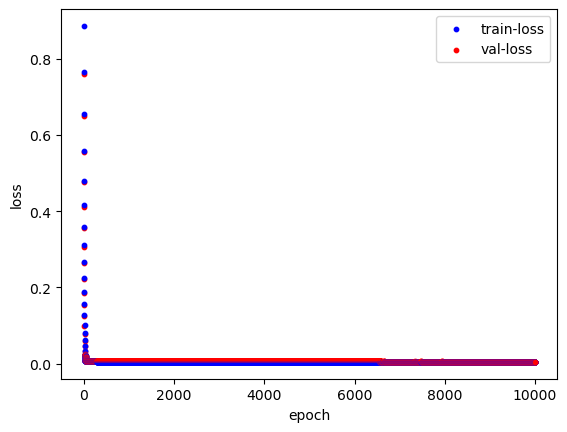

In [15]:
#%% Training
plt.figure() # monitor loss curve during training
# for loop over epochs
for epoch in range(num_epoch):
    # classical forward pass -> predict new output from train data
    Y_pred_train = net(X_train)
    # compute loss    
    loss_train = loss_func(Y_pred_train, Y_train)
    
    # Compute gradients
    optimizer.zero_grad()
    # Calling .backward() mutiple times accumulates the gradient (by addition) for each parameter. This is why you should call optimizer.zero_grad() after each .step() call
    # Note that following the first .backward call, a second call is only possible after you have performed another forward pass.
    loss_train.backward()
    # perform a parameter update based on the current gradient (stored in .grad attribute of a parameter)
    optimizer.step()
    
    # TODO**
    # forward pass for validation
    Y_pred_val = net(X_val)
    loss_val = loss_func(Y_pred_val, Y_val)
    # TODO**
    
    # plot train and val loss
    plt.scatter(epoch, loss_train.data.item(), color='b', s=10, marker='o')    
    plt.scatter(epoch, loss_val.data.item(), color='r', s=10, marker='o')
    
    # print message with actual losses
    print('Train Epoch: {}/{} ({:.0f}%)\ttrain_Loss: {:.6f}\tval_Loss: {:.6f}'.format(
    epoch+1, num_epoch, epoch/num_epoch*100, loss_train.item(), loss_val.item()))


# show training and validation loss    
plt.legend(['train-loss','val-loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig(os.path.join(path, 'results/who_loss.png'))
#plt.show()

print('Train loss before training was:', loss_train_before.item())
print('Train loss after training is:', loss_train.item())
print('Val loss before training was:', loss_val_before.item())
print('Val loss after training is:', loss_val.item())

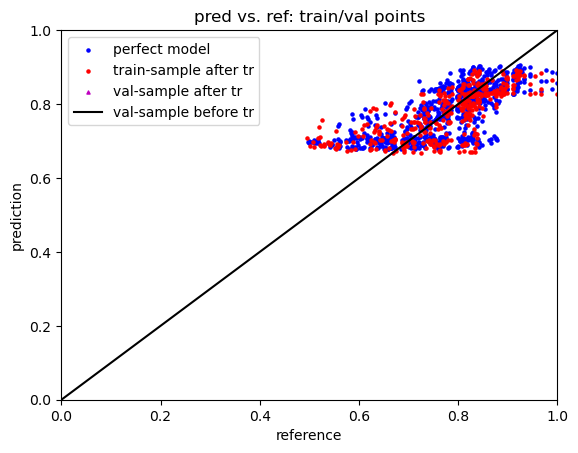

In [16]:
#%% Pred vs. Ref Figure Train/Val set
# plot the prediction against the reference for the train/val points
# if the prediction equals the reference the dots will appear at the 'perfect model' line
plt.figure()
plt.title('pred vs. ref: train/val points')
plt.scatter(Y_train.cpu().numpy(), Y_pred_train.cpu().detach().numpy(), color='b', s=5, marker='o')
plt.scatter(Y_val.cpu().numpy(), Y_pred_val.cpu().detach().numpy(), color='r', s=5, marker='o')
plt.scatter(Y_val.cpu().numpy(), Y_pred_val_before.cpu().detach().numpy(), color='m', s=5, marker='^')
plt.plot((0,1),(0,1), color='k')
plt.xlabel('reference')
plt.ylabel('prediction')
plt.legend(['perfect model', 'train-sample after tr','val-sample after tr', 'val-sample before tr'])
plt.xlim((0,1))
plt.ylim((0,1))
plt.savefig(os.path.join(path, 'results/who_pred_vs_ref_val.png'))

In [18]:
#%% Test results
# TODO**
# forward pass 
# Y_pred_test_oh is on the GPU, because net and X_test are on the GPU, but we want it on the CPU from now on.
Y_pred_test = net(X_test)
loss_test = loss_func(Y_pred_test, Y_test)
# TODO**
print('Test loss before training was:', loss_test_before.item())
print('Test loss after training is:', loss_test.item())

# Plot mean abs difference between prediction and reference
print('Mean abs difference:', np.mean(abs(Y_pred_test.cpu().detach().numpy()-Y_test.cpu().numpy()), axis=0)*scale_y, 'years')

Test loss before training was: 0.9002924561500549
Test loss after training is: 0.004692372400313616
Mean abs difference: [4.798153] years


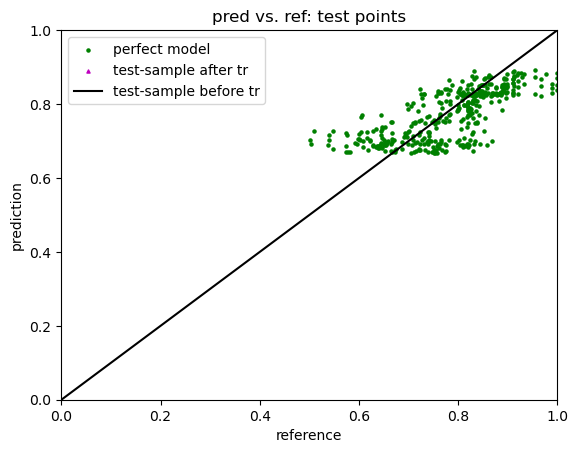

In [19]:
#%% Pred vs. Ref Figure Test set
# plot the prediction against the reference for the test points
# if the prediction equals the reference the dots will appear at the 'perfect model' line
plt.figure()
plt.title('pred vs. ref: test points')
plt.scatter(Y_test.cpu().numpy(), Y_pred_test.cpu().detach().numpy(), color='g', s=5, marker='o')
plt.scatter(Y_test.cpu().numpy(), Y_pred_test_before.cpu().detach().numpy(), color='m', s=5, marker='^')
plt.plot((0,1),(0,1), color='k')
plt.xlabel('reference')
plt.ylabel('prediction')
plt.legend(['perfect model','test-sample after tr', 'test-sample before tr'])
plt.xlim((0,1))
plt.ylim((0,1))
plt.savefig(os.path.join(path, 'results/who_pred_vs_ref_test.png'))